# Predict Future Sale - Baseline
## Final project for "How to win a data science competition" Coursera course
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data  
>Student: Rafael Caneiro de Oliveira  
>Email: rafael.caneiro@gmail.com  
>Date: 04/08/2020

## Load

In [2]:
import numpy as np
import pandas as pd
from itertools import product

from pathlib import Path

PATH = Path.cwd().parent
DATA_PATH = Path(PATH, "./data/raw/") 
MODEL_PATH = Path(PATH, "./models/") 

In [3]:
sales = pd.read_csv(Path(DATA_PATH,"sales_train.csv"))
items = pd.read_csv(Path(DATA_PATH,"items.csv"))
categories = pd.read_csv(Path(DATA_PATH,"item_categories.csv"))
shops = pd.read_csv(Path(DATA_PATH,"shops.csv"))
test = pd.read_csv(Path(DATA_PATH,"test.csv"))
test["date_block_num"]=34

## Aggregate

In [4]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})

#fix column names
gb.rename({"item_cnt_day":"target"}, inplace=True, axis=1)

#join aggregated data to the grid
train = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#sort the data
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

## Join

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
train = train.merge(items, on="item_id", how="left")
train = train.merge(categories, on="item_category_id", how="left")
train = train.merge(shops, on="shop_id", how="left")
train.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
train = reduce_mem_usage(train)
train.head() 

Memory usage after optimization is: 156.12 MB
Decreased by 58.3%


,shop_id,item_id,date_block_num,target,item_category_id
0,0,19,0,0.0,40
1,0,27,0,0.0,19
2,0,28,0,0.0,30
3,0,29,0,0.0,23
4,0,32,0,6.0,40


In [7]:
test = test.merge(items, on="item_id", how="left")
test = test.merge(categories, on="item_category_id", how="left")
test = test.merge(shops, on="shop_id", how="left")
test.drop(columns=["item_name", "shop_name", "item_category_name"], inplace=True)
test = reduce_mem_usage(test)
test.head()

Memory usage after optimization is: 3.47 MB
Decreased by 64.6%


,ID,shop_id,item_id,date_block_num,item_category_id
0,0,5,5037,34,19
1,1,5,5320,34,55
2,2,5,5233,34,19
3,3,5,5232,34,23
4,4,5,5268,34,20


## Test / Validation Split

In [8]:
def get_index(start, end, df, col):
    ls = [x for x in range(start , end + 1)]
    idx = df[df[col].isin(ls)].index.ravel()
    return idx

# 2013-jan >> 2013-oct
train_1 = get_index(0, 10, train, "date_block_num")

# 2013-nov
val_1 = get_index(10, 10, train, "date_block_num")

# 2014-jan >> 2014-oct
train_2 = get_index(12, 22, train, "date_block_num")

# 2014-nov
val_2 = get_index(22, 22, train, "date_block_num")

# 2015-jan >> 2015-sep
train_3 = get_index(24, 33, train, "date_block_num")

# 2015-oct
val_3 = get_index(33, 33, train, "date_block_num")

# 2013-jan >> 2015-sep
train_val = get_index(0, 33, train, "date_block_num")

# 2013-jan >> 2015-out
train_all = get_index(0, 34, train, "date_block_num")

folds = [(train_1, val_1), (train_2, val_2), (train_3, val_3)]

## Features / Target

In [9]:
remove_cols = ["target", "item_name", "item_category_name", "shop_name"]
features = [col for col in train.columns if col not in remove_cols]
target="target"

## General Approach for Parameter Tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Step 1 - Adjust the learning rate
In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

- max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
- min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
- gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
- subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
- scale_pos_weight = 1: Because of high class imbalance.  
   
Please note that all the above are just initial estimates and will be tuned later. Lets take the default learning rate of 0.1 here and check the optimum number of trees using cv function of xgboost. The function defined above will do it for us.

In [18]:
import xgboost as xgb

xgtrain = xgb.DMatrix(data=train[features].values,
                      label=train[target].values)

parameters = {"eta":0.3,
              "gamma":0,
              "max_depth":5,
              "min_child_weight":1,
              "subsample":0.8,
              "colsample_bytree":0.8}

num_boost_round = 10000
metric = "rmse"
early_stopping_rounds = None

cv_model = xgb.cv(params=parameters, 
                  dtrain=xgtrain,
                  num_boost_round=num_boost_round,
                  folds=folds,
                  metrics=metric,
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=True,
                  seed=42)

[0]	train-rmse:3.18876+0.42815	test-rmse:4.32947+0.68203
[1]	train-rmse:3.06625+0.47243	test-rmse:4.18011+0.77315
[2]	train-rmse:3.03844+0.48536	test-rmse:4.15395+0.78560
[3]	train-rmse:2.98183+0.47992	test-rmse:4.09288+0.80931
[4]	train-rmse:2.94056+0.48933	test-rmse:4.02799+0.84140
[5]	train-rmse:2.89053+0.50215	test-rmse:3.98013+0.85360
[6]	train-rmse:2.85921+0.51853	test-rmse:3.94061+0.88314
[7]	train-rmse:2.84097+0.52143	test-rmse:3.90826+0.89722
[8]	train-rmse:2.81545+0.51779	test-rmse:3.87452+0.87334
[9]	train-rmse:2.79853+0.52229	test-rmse:3.85260+0.89100
[10]	train-rmse:2.79129+0.51547	test-rmse:3.85211+0.89134
[11]	train-rmse:2.77669+0.51997	test-rmse:3.84886+0.88832
[12]	train-rmse:2.76862+0.51074	test-rmse:3.84932+0.88928
[13]	train-rmse:2.74597+0.52547	test-rmse:3.81497+0.92429
[14]	train-rmse:2.73947+0.52871	test-rmse:3.80935+0.92648
[15]	train-rmse:2.73589+0.52510	test-rmse:3.80164+0.91844
[16]	train-rmse:2.72397+0.51002	test-rmse:3.80371+0.92284
[17]	train-rmse:2.72291+

[141]	train-rmse:2.22617+0.48182	test-rmse:3.08155+0.94933
[142]	train-rmse:2.22394+0.48268	test-rmse:3.07662+0.95142
[143]	train-rmse:2.22309+0.48256	test-rmse:3.07402+0.94855
[144]	train-rmse:2.20977+0.46432	test-rmse:2.98209+0.82249
[145]	train-rmse:2.20926+0.46452	test-rmse:2.98131+0.82263
[146]	train-rmse:2.20914+0.46487	test-rmse:2.98190+0.82450
[147]	train-rmse:2.20810+0.46433	test-rmse:2.97926+0.82041
[148]	train-rmse:2.19659+0.44876	test-rmse:2.97851+0.82054
[149]	train-rmse:2.19648+0.44900	test-rmse:2.97874+0.82245
[150]	train-rmse:2.19557+0.44913	test-rmse:2.97759+0.82086
[151]	train-rmse:2.19490+0.44951	test-rmse:2.97772+0.82080
[152]	train-rmse:2.19429+0.44952	test-rmse:2.97628+0.82107
[153]	train-rmse:2.19349+0.44992	test-rmse:2.97614+0.82117
[154]	train-rmse:2.19163+0.44794	test-rmse:2.96721+0.80913
[155]	train-rmse:2.19105+0.44815	test-rmse:2.96706+0.80902
[156]	train-rmse:2.19069+0.44820	test-rmse:2.96661+0.80916
[157]	train-rmse:2.19054+0.44841	test-rmse:2.96658+0.809

[280]	train-rmse:2.04055+0.42325	test-rmse:2.73425+0.83574
[281]	train-rmse:2.04025+0.42321	test-rmse:2.73445+0.83610
[282]	train-rmse:2.04026+0.42313	test-rmse:2.73442+0.83612
[283]	train-rmse:2.03675+0.41826	test-rmse:2.73399+0.83560
[284]	train-rmse:2.03646+0.41823	test-rmse:2.73366+0.83557
[285]	train-rmse:2.03624+0.41818	test-rmse:2.73315+0.83537
[286]	train-rmse:2.03476+0.41860	test-rmse:2.73099+0.83645
[287]	train-rmse:2.03452+0.41917	test-rmse:2.73203+0.83865
[288]	train-rmse:2.03354+0.41851	test-rmse:2.73204+0.83864
[289]	train-rmse:2.03235+0.41761	test-rmse:2.73220+0.83862
[290]	train-rmse:2.03218+0.41767	test-rmse:2.73197+0.83836
[291]	train-rmse:2.03157+0.41821	test-rmse:2.72734+0.84171
[292]	train-rmse:2.03107+0.41806	test-rmse:2.72577+0.83960
[293]	train-rmse:2.03080+0.41807	test-rmse:2.72474+0.84054
[294]	train-rmse:2.03041+0.41815	test-rmse:2.72455+0.84045
[295]	train-rmse:2.03063+0.41850	test-rmse:2.72456+0.84044
[296]	train-rmse:2.02775+0.41996	test-rmse:2.72204+0.841

[419]	train-rmse:1.91413+0.38147	test-rmse:2.54408+0.74125
[420]	train-rmse:1.91395+0.38152	test-rmse:2.54407+0.74135
[421]	train-rmse:1.91373+0.38163	test-rmse:2.54322+0.74204
[422]	train-rmse:1.91301+0.38108	test-rmse:2.54199+0.74170
[423]	train-rmse:1.91354+0.38237	test-rmse:2.54760+0.74993
[424]	train-rmse:1.91349+0.38236	test-rmse:2.54749+0.74992
[425]	train-rmse:1.91324+0.38230	test-rmse:2.54748+0.74995
[426]	train-rmse:1.91240+0.38135	test-rmse:2.54738+0.74989
[427]	train-rmse:1.91219+0.38144	test-rmse:2.54754+0.74968
[428]	train-rmse:1.91211+0.38142	test-rmse:2.54769+0.74987
[429]	train-rmse:1.90828+0.37613	test-rmse:2.54773+0.74989
[430]	train-rmse:1.90824+0.37611	test-rmse:2.54774+0.74988
[431]	train-rmse:1.90800+0.37586	test-rmse:2.54625+0.74806
[432]	train-rmse:1.90787+0.37583	test-rmse:2.54619+0.74807
[433]	train-rmse:1.90674+0.37568	test-rmse:2.54184+0.74818
[434]	train-rmse:1.90584+0.37518	test-rmse:2.53463+0.73868
[435]	train-rmse:1.90597+0.37553	test-rmse:2.53683+0.741

[558]	train-rmse:1.82449+0.32982	test-rmse:2.36419+0.61880
[559]	train-rmse:1.82442+0.32981	test-rmse:2.36397+0.61848
[560]	train-rmse:1.82426+0.32983	test-rmse:2.36377+0.61828
[561]	train-rmse:1.82399+0.32978	test-rmse:2.36345+0.61835
[562]	train-rmse:1.82401+0.32978	test-rmse:2.36275+0.61850
[563]	train-rmse:1.82380+0.32982	test-rmse:2.36235+0.61866
[564]	train-rmse:1.82387+0.33029	test-rmse:2.36228+0.61865
[565]	train-rmse:1.82409+0.33089	test-rmse:2.36203+0.61842
[566]	train-rmse:1.82406+0.33090	test-rmse:2.36199+0.61844
[567]	train-rmse:1.82317+0.33158	test-rmse:2.36345+0.62045
[568]	train-rmse:1.82295+0.33139	test-rmse:2.36334+0.62050
[569]	train-rmse:1.82201+0.33027	test-rmse:2.36527+0.62395
[570]	train-rmse:1.82182+0.33027	test-rmse:2.36512+0.62395
[571]	train-rmse:1.82038+0.32919	test-rmse:2.36191+0.62698
[572]	train-rmse:1.82032+0.32928	test-rmse:2.36207+0.62671
[573]	train-rmse:1.82027+0.32934	test-rmse:2.36133+0.62736
[574]	train-rmse:1.82047+0.32993	test-rmse:2.36131+0.627

[697]	train-rmse:1.77697+0.33263	test-rmse:2.31913+0.64447
[698]	train-rmse:1.77607+0.33141	test-rmse:2.31895+0.64451
[699]	train-rmse:1.77579+0.33147	test-rmse:2.31551+0.64432
[700]	train-rmse:1.77522+0.33159	test-rmse:2.31506+0.64434
[701]	train-rmse:1.77498+0.33145	test-rmse:2.31281+0.64253
[702]	train-rmse:1.77475+0.33127	test-rmse:2.31276+0.64250
[703]	train-rmse:1.77462+0.33127	test-rmse:2.31293+0.64228
[704]	train-rmse:1.77434+0.33138	test-rmse:2.31208+0.64326
[705]	train-rmse:1.77426+0.33132	test-rmse:2.31204+0.64326
[706]	train-rmse:1.77415+0.33124	test-rmse:2.31203+0.64326
[707]	train-rmse:1.77401+0.33146	test-rmse:2.31198+0.64331
[708]	train-rmse:1.77438+0.33119	test-rmse:2.30573+0.64423
[709]	train-rmse:1.77424+0.33103	test-rmse:2.30503+0.64338
[710]	train-rmse:1.77416+0.33104	test-rmse:2.30529+0.64377
[711]	train-rmse:1.77458+0.33172	test-rmse:2.30495+0.64348
[712]	train-rmse:1.77397+0.33159	test-rmse:2.30864+0.65102
[713]	train-rmse:1.77039+0.32809	test-rmse:2.31668+0.649

[836]	train-rmse:1.70956+0.30499	test-rmse:2.14686+0.52712
[837]	train-rmse:1.70939+0.30506	test-rmse:2.14696+0.52721
[838]	train-rmse:1.70980+0.30565	test-rmse:2.14840+0.52909
[839]	train-rmse:1.70827+0.30358	test-rmse:2.14826+0.52892
[840]	train-rmse:1.70812+0.30361	test-rmse:2.14830+0.52885
[841]	train-rmse:1.70803+0.30352	test-rmse:2.14825+0.52879
[842]	train-rmse:1.70821+0.30355	test-rmse:2.14826+0.52899
[843]	train-rmse:1.70806+0.30365	test-rmse:2.14739+0.52969
[844]	train-rmse:1.70772+0.30321	test-rmse:2.14641+0.52855
[845]	train-rmse:1.70710+0.30238	test-rmse:2.14631+0.52846
[846]	train-rmse:1.70670+0.30270	test-rmse:2.14588+0.52868
[847]	train-rmse:1.70710+0.30333	test-rmse:2.15024+0.53427
[848]	train-rmse:1.70704+0.30351	test-rmse:2.14955+0.53493
[849]	train-rmse:1.70691+0.30341	test-rmse:2.14968+0.53516
[850]	train-rmse:1.70659+0.30303	test-rmse:2.14928+0.53471
[851]	train-rmse:1.70620+0.30284	test-rmse:2.14903+0.53461
[852]	train-rmse:1.70600+0.30290	test-rmse:2.14895+0.534

[975]	train-rmse:1.66692+0.27944	test-rmse:2.13563+0.56106
[976]	train-rmse:1.66663+0.27958	test-rmse:2.13527+0.56092
[977]	train-rmse:1.66622+0.27916	test-rmse:2.13497+0.56091
[978]	train-rmse:1.66603+0.27933	test-rmse:2.13438+0.56134
[979]	train-rmse:1.66606+0.27927	test-rmse:2.13460+0.56149
[980]	train-rmse:1.66521+0.27841	test-rmse:2.13206+0.55857
[981]	train-rmse:1.66459+0.27788	test-rmse:2.13201+0.55861
[982]	train-rmse:1.66454+0.27784	test-rmse:2.13191+0.55852
[983]	train-rmse:1.66430+0.27804	test-rmse:2.13087+0.55961
[984]	train-rmse:1.66418+0.27821	test-rmse:2.13101+0.55999
[985]	train-rmse:1.66392+0.27836	test-rmse:2.13083+0.55972
[986]	train-rmse:1.66338+0.27868	test-rmse:2.14537+0.55828
[987]	train-rmse:1.66332+0.27869	test-rmse:2.14533+0.55824
[988]	train-rmse:1.66329+0.27873	test-rmse:2.14533+0.55820
[989]	train-rmse:1.66316+0.27884	test-rmse:2.14533+0.55845
[990]	train-rmse:1.66293+0.27875	test-rmse:2.14583+0.55960
[991]	train-rmse:1.66278+0.27861	test-rmse:2.14470+0.558

[1112]	train-rmse:1.62470+0.25681	test-rmse:1.97379+0.40479
[1113]	train-rmse:1.62477+0.25713	test-rmse:1.97352+0.40508
[1114]	train-rmse:1.62490+0.25743	test-rmse:1.97341+0.40499
[1115]	train-rmse:1.62471+0.25741	test-rmse:1.97256+0.40381
[1116]	train-rmse:1.62354+0.25586	test-rmse:1.97264+0.40408
[1117]	train-rmse:1.62347+0.25579	test-rmse:1.97198+0.40331
[1118]	train-rmse:1.62347+0.25582	test-rmse:1.97197+0.40336
[1119]	train-rmse:1.62341+0.25569	test-rmse:1.97212+0.40340
[1120]	train-rmse:1.61869+0.24939	test-rmse:1.98495+0.40476
[1121]	train-rmse:1.61860+0.24943	test-rmse:1.98491+0.40475
[1122]	train-rmse:1.61852+0.24949	test-rmse:1.98475+0.40480
[1123]	train-rmse:1.61839+0.24954	test-rmse:1.98446+0.40493
[1124]	train-rmse:1.61825+0.24937	test-rmse:1.98490+0.40542
[1125]	train-rmse:1.61785+0.24948	test-rmse:1.98447+0.40590
[1126]	train-rmse:1.61761+0.24922	test-rmse:1.98423+0.40574
[1127]	train-rmse:1.61744+0.24930	test-rmse:1.98409+0.40594
[1128]	train-rmse:1.61688+0.24966	test-r

[1249]	train-rmse:1.58704+0.23866	test-rmse:1.90494+0.36322
[1250]	train-rmse:1.58700+0.23866	test-rmse:1.90557+0.36332
[1251]	train-rmse:1.58688+0.23860	test-rmse:1.90481+0.36261
[1252]	train-rmse:1.58684+0.23853	test-rmse:1.90478+0.36265
[1253]	train-rmse:1.58681+0.23849	test-rmse:1.90468+0.36254
[1254]	train-rmse:1.58670+0.23832	test-rmse:1.90465+0.36256
[1255]	train-rmse:1.58644+0.23857	test-rmse:1.90441+0.36231
[1256]	train-rmse:1.58635+0.23849	test-rmse:1.90436+0.36233
[1257]	train-rmse:1.58633+0.23822	test-rmse:1.90648+0.36203
[1258]	train-rmse:1.58642+0.23838	test-rmse:1.90654+0.36190
[1259]	train-rmse:1.58639+0.23847	test-rmse:1.90627+0.36206
[1260]	train-rmse:1.58623+0.23831	test-rmse:1.90604+0.36202
[1261]	train-rmse:1.58621+0.23839	test-rmse:1.90606+0.36193
[1262]	train-rmse:1.58620+0.23842	test-rmse:1.90597+0.36189
[1263]	train-rmse:1.58608+0.23837	test-rmse:1.90597+0.36195
[1264]	train-rmse:1.58600+0.23830	test-rmse:1.90593+0.36203
[1265]	train-rmse:1.58586+0.23834	test-r

[1386]	train-rmse:1.55891+0.22572	test-rmse:1.85909+0.35796
[1387]	train-rmse:1.55872+0.22552	test-rmse:1.85813+0.35673
[1388]	train-rmse:1.55862+0.22548	test-rmse:1.85800+0.35667
[1389]	train-rmse:1.55850+0.22537	test-rmse:1.85795+0.35665
[1390]	train-rmse:1.55840+0.22534	test-rmse:1.85748+0.35607
[1391]	train-rmse:1.55644+0.22262	test-rmse:1.85703+0.35556
[1392]	train-rmse:1.55644+0.22259	test-rmse:1.85656+0.35549
[1393]	train-rmse:1.55549+0.22139	test-rmse:1.84938+0.34676
[1394]	train-rmse:1.55539+0.22119	test-rmse:1.84981+0.34791
[1395]	train-rmse:1.55532+0.22115	test-rmse:1.84924+0.34796
[1396]	train-rmse:1.55527+0.22111	test-rmse:1.84921+0.34798
[1397]	train-rmse:1.55524+0.22110	test-rmse:1.84916+0.34803
[1398]	train-rmse:1.55503+0.22124	test-rmse:1.84904+0.34807
[1399]	train-rmse:1.55502+0.22120	test-rmse:1.84778+0.34865
[1400]	train-rmse:1.55518+0.22145	test-rmse:1.84766+0.34851
[1401]	train-rmse:1.55488+0.22160	test-rmse:1.84680+0.34853
[1402]	train-rmse:1.55473+0.22174	test-r

[1523]	train-rmse:1.52586+0.20253	test-rmse:1.77673+0.28466
[1524]	train-rmse:1.52568+0.20240	test-rmse:1.77644+0.28442
[1525]	train-rmse:1.52570+0.20249	test-rmse:1.77638+0.28438
[1526]	train-rmse:1.52558+0.20237	test-rmse:1.77704+0.28441
[1527]	train-rmse:1.52545+0.20227	test-rmse:1.77695+0.28440
[1528]	train-rmse:1.52492+0.20241	test-rmse:1.77189+0.28340
[1529]	train-rmse:1.52438+0.20174	test-rmse:1.77180+0.28341
[1530]	train-rmse:1.52437+0.20170	test-rmse:1.77312+0.28341
[1531]	train-rmse:1.52444+0.20189	test-rmse:1.77340+0.28376
[1532]	train-rmse:1.52441+0.20182	test-rmse:1.77320+0.28400
[1533]	train-rmse:1.52401+0.20194	test-rmse:1.77276+0.28457
[1534]	train-rmse:1.52392+0.20200	test-rmse:1.77191+0.28446
[1535]	train-rmse:1.52371+0.20215	test-rmse:1.77237+0.28363
[1536]	train-rmse:1.52376+0.20228	test-rmse:1.77318+0.28451
[1537]	train-rmse:1.52366+0.20265	test-rmse:1.77412+0.28707
[1538]	train-rmse:1.52366+0.20281	test-rmse:1.77411+0.28707
[1539]	train-rmse:1.52368+0.20283	test-r

[1660]	train-rmse:1.50380+0.19193	test-rmse:1.71645+0.23962
[1661]	train-rmse:1.50374+0.19192	test-rmse:1.71648+0.23984
[1662]	train-rmse:1.50371+0.19197	test-rmse:1.71750+0.24022
[1663]	train-rmse:1.50364+0.19199	test-rmse:1.71750+0.24026
[1664]	train-rmse:1.50312+0.19129	test-rmse:1.71727+0.23995
[1665]	train-rmse:1.50217+0.19009	test-rmse:1.70944+0.23303
[1666]	train-rmse:1.50237+0.18996	test-rmse:1.70946+0.23304
[1667]	train-rmse:1.50210+0.19000	test-rmse:1.70871+0.23360
[1668]	train-rmse:1.50209+0.19002	test-rmse:1.70870+0.23360
[1669]	train-rmse:1.50125+0.19062	test-rmse:1.70860+0.23343
[1670]	train-rmse:1.50124+0.19061	test-rmse:1.70847+0.23338
[1671]	train-rmse:1.50093+0.19064	test-rmse:1.70835+0.23352
[1672]	train-rmse:1.50058+0.19057	test-rmse:1.70849+0.23360
[1673]	train-rmse:1.50056+0.19057	test-rmse:1.70853+0.23352
[1674]	train-rmse:1.50053+0.19056	test-rmse:1.70844+0.23346
[1675]	train-rmse:1.50051+0.19058	test-rmse:1.70842+0.23347
[1676]	train-rmse:1.50046+0.19071	test-r

[1797]	train-rmse:1.48469+0.18246	test-rmse:1.66839+0.20517
[1798]	train-rmse:1.48422+0.18262	test-rmse:1.66436+0.20340
[1799]	train-rmse:1.48420+0.18265	test-rmse:1.66439+0.20337
[1800]	train-rmse:1.48387+0.18274	test-rmse:1.66353+0.20258
[1801]	train-rmse:1.48374+0.18266	test-rmse:1.66313+0.20219
[1802]	train-rmse:1.48345+0.18288	test-rmse:1.66198+0.20177
[1803]	train-rmse:1.48336+0.18280	test-rmse:1.65873+0.19860
[1804]	train-rmse:1.48340+0.18289	test-rmse:1.65884+0.19876
[1805]	train-rmse:1.48336+0.18291	test-rmse:1.65905+0.19885
[1806]	train-rmse:1.48255+0.18178	test-rmse:1.65898+0.19881
[1807]	train-rmse:1.48224+0.18141	test-rmse:1.65980+0.20040
[1808]	train-rmse:1.48225+0.18140	test-rmse:1.65990+0.20036
[1809]	train-rmse:1.48214+0.18149	test-rmse:1.65961+0.20026
[1810]	train-rmse:1.48178+0.18159	test-rmse:1.65962+0.20025
[1811]	train-rmse:1.48181+0.18159	test-rmse:1.65959+0.20024
[1812]	train-rmse:1.48177+0.18156	test-rmse:1.65958+0.20026
[1813]	train-rmse:1.48173+0.18154	test-r

[1934]	train-rmse:1.46822+0.17582	test-rmse:1.62880+0.17312
[1935]	train-rmse:1.46799+0.17594	test-rmse:1.62876+0.17309
[1936]	train-rmse:1.46790+0.17581	test-rmse:1.62870+0.17313
[1937]	train-rmse:1.46778+0.17576	test-rmse:1.62870+0.17310
[1938]	train-rmse:1.46768+0.17567	test-rmse:1.62824+0.17264
[1939]	train-rmse:1.46741+0.17559	test-rmse:1.62808+0.17256
[1940]	train-rmse:1.46705+0.17574	test-rmse:1.62742+0.17333
[1941]	train-rmse:1.46708+0.17572	test-rmse:1.62740+0.17335
[1942]	train-rmse:1.46701+0.17569	test-rmse:1.62740+0.17334
[1943]	train-rmse:1.46699+0.17568	test-rmse:1.62752+0.17343
[1944]	train-rmse:1.46692+0.17568	test-rmse:1.63180+0.17702
[1945]	train-rmse:1.46686+0.17560	test-rmse:1.63185+0.17706
[1946]	train-rmse:1.46674+0.17534	test-rmse:1.63205+0.17719
[1947]	train-rmse:1.46667+0.17543	test-rmse:1.63174+0.17746
[1948]	train-rmse:1.46657+0.17534	test-rmse:1.63183+0.17753
[1949]	train-rmse:1.46655+0.17541	test-rmse:1.63193+0.17755
[1950]	train-rmse:1.46648+0.17533	test-r

[2071]	train-rmse:1.44719+0.16404	test-rmse:1.58971+0.15810
[2072]	train-rmse:1.44712+0.16411	test-rmse:1.58973+0.15805
[2073]	train-rmse:1.44712+0.16415	test-rmse:1.58974+0.15808
[2074]	train-rmse:1.44708+0.16414	test-rmse:1.58946+0.15791
[2075]	train-rmse:1.44709+0.16409	test-rmse:1.59000+0.15707
[2076]	train-rmse:1.44695+0.16406	test-rmse:1.59013+0.15716
[2077]	train-rmse:1.44639+0.16341	test-rmse:1.59014+0.15717
[2078]	train-rmse:1.44625+0.16359	test-rmse:1.59009+0.15729
[2079]	train-rmse:1.44621+0.16361	test-rmse:1.58970+0.15699
[2080]	train-rmse:1.44599+0.16355	test-rmse:1.59019+0.15710
[2081]	train-rmse:1.44588+0.16353	test-rmse:1.59002+0.15738
[2082]	train-rmse:1.44579+0.16358	test-rmse:1.58994+0.15747
[2083]	train-rmse:1.44576+0.16357	test-rmse:1.58990+0.15746
[2084]	train-rmse:1.44516+0.16381	test-rmse:1.58841+0.15654
[2085]	train-rmse:1.44509+0.16373	test-rmse:1.58843+0.15657
[2086]	train-rmse:1.44487+0.16400	test-rmse:1.58849+0.15649
[2087]	train-rmse:1.44490+0.16405	test-r

[2208]	train-rmse:1.43314+0.16072	test-rmse:1.57441+0.15384
[2209]	train-rmse:1.43297+0.16047	test-rmse:1.57456+0.15393
[2210]	train-rmse:1.43291+0.16044	test-rmse:1.57458+0.15396
[2211]	train-rmse:1.43289+0.16040	test-rmse:1.57500+0.15431
[2212]	train-rmse:1.43288+0.16038	test-rmse:1.57482+0.15450
[2213]	train-rmse:1.43280+0.16043	test-rmse:1.57477+0.15438
[2214]	train-rmse:1.43279+0.16042	test-rmse:1.57471+0.15434
[2215]	train-rmse:1.43276+0.16037	test-rmse:1.57475+0.15437
[2216]	train-rmse:1.43260+0.16031	test-rmse:1.57427+0.15400
[2217]	train-rmse:1.43264+0.16042	test-rmse:1.57453+0.15423
[2218]	train-rmse:1.43263+0.16047	test-rmse:1.57444+0.15422
[2219]	train-rmse:1.43264+0.16049	test-rmse:1.57443+0.15422
[2220]	train-rmse:1.43241+0.16054	test-rmse:1.57444+0.15421
[2221]	train-rmse:1.43237+0.16057	test-rmse:1.57444+0.15417
[2222]	train-rmse:1.43236+0.16059	test-rmse:1.57444+0.15409
[2223]	train-rmse:1.43225+0.16064	test-rmse:1.57332+0.15317
[2224]	train-rmse:1.43215+0.16064	test-r

[2345]	train-rmse:1.42137+0.15928	test-rmse:1.58267+0.16600
[2346]	train-rmse:1.42125+0.15937	test-rmse:1.58281+0.16619
[2347]	train-rmse:1.42102+0.15900	test-rmse:1.58380+0.16696
[2348]	train-rmse:1.42097+0.15895	test-rmse:1.58366+0.16676
[2349]	train-rmse:1.42094+0.15896	test-rmse:1.58370+0.16677
[2350]	train-rmse:1.42085+0.15895	test-rmse:1.58372+0.16665
[2351]	train-rmse:1.42096+0.15880	test-rmse:1.58353+0.16652
[2352]	train-rmse:1.42093+0.15879	test-rmse:1.58338+0.16642
[2353]	train-rmse:1.42151+0.15966	test-rmse:1.59391+0.17493
[2354]	train-rmse:1.42147+0.15971	test-rmse:1.59378+0.17523
[2355]	train-rmse:1.42141+0.15968	test-rmse:1.59486+0.17613
[2356]	train-rmse:1.42137+0.15965	test-rmse:1.59485+0.17620
[2357]	train-rmse:1.42127+0.15970	test-rmse:1.59480+0.17615
[2358]	train-rmse:1.42131+0.15972	test-rmse:1.59442+0.17594
[2359]	train-rmse:1.42110+0.15957	test-rmse:1.59405+0.17579
[2360]	train-rmse:1.42108+0.15959	test-rmse:1.59401+0.17580
[2361]	train-rmse:1.42116+0.15991	test-r

[2482]	train-rmse:1.40547+0.14569	test-rmse:1.57791+0.16730
[2483]	train-rmse:1.40498+0.14602	test-rmse:1.57389+0.16494
[2484]	train-rmse:1.40495+0.14612	test-rmse:1.57375+0.16476
[2485]	train-rmse:1.40491+0.14612	test-rmse:1.57411+0.16507
[2486]	train-rmse:1.40487+0.14609	test-rmse:1.57397+0.16505
[2487]	train-rmse:1.40477+0.14601	test-rmse:1.57394+0.16519
[2488]	train-rmse:1.40465+0.14586	test-rmse:1.57358+0.16486
[2489]	train-rmse:1.40464+0.14586	test-rmse:1.57331+0.16473
[2490]	train-rmse:1.40461+0.14584	test-rmse:1.57334+0.16474
[2491]	train-rmse:1.40442+0.14596	test-rmse:1.57211+0.16406
[2492]	train-rmse:1.40435+0.14589	test-rmse:1.57204+0.16401
[2493]	train-rmse:1.40428+0.14595	test-rmse:1.57191+0.16420
[2494]	train-rmse:1.40423+0.14599	test-rmse:1.57188+0.16416
[2495]	train-rmse:1.40416+0.14604	test-rmse:1.57179+0.16427
[2496]	train-rmse:1.40417+0.14610	test-rmse:1.57188+0.16436
[2497]	train-rmse:1.40411+0.14610	test-rmse:1.57182+0.16431
[2498]	train-rmse:1.40406+0.14611	test-r

[2619]	train-rmse:1.39652+0.14428	test-rmse:1.56378+0.16474
[2620]	train-rmse:1.39651+0.14431	test-rmse:1.56363+0.16464
[2621]	train-rmse:1.39646+0.14434	test-rmse:1.56363+0.16448
[2622]	train-rmse:1.39646+0.14435	test-rmse:1.56365+0.16450
[2623]	train-rmse:1.39643+0.14435	test-rmse:1.56364+0.16452
[2624]	train-rmse:1.39640+0.14440	test-rmse:1.56359+0.16441
[2625]	train-rmse:1.39638+0.14443	test-rmse:1.56350+0.16439
[2626]	train-rmse:1.39626+0.14428	test-rmse:1.56245+0.16352
[2627]	train-rmse:1.39619+0.14429	test-rmse:1.56239+0.16352
[2628]	train-rmse:1.39620+0.14431	test-rmse:1.56248+0.16362
[2629]	train-rmse:1.39627+0.14451	test-rmse:1.56241+0.16360
[2630]	train-rmse:1.39615+0.14456	test-rmse:1.56212+0.16414
[2631]	train-rmse:1.39620+0.14466	test-rmse:1.56197+0.16404
[2632]	train-rmse:1.39615+0.14460	test-rmse:1.56188+0.16401
[2633]	train-rmse:1.39608+0.14459	test-rmse:1.56163+0.16427
[2634]	train-rmse:1.39585+0.14473	test-rmse:1.55992+0.16334
[2635]	train-rmse:1.39583+0.14478	test-r

[2756]	train-rmse:1.38492+0.14073	test-rmse:1.54566+0.16549
[2757]	train-rmse:1.38491+0.14073	test-rmse:1.54578+0.16562
[2758]	train-rmse:1.38486+0.14076	test-rmse:1.54586+0.16568
[2759]	train-rmse:1.38489+0.14082	test-rmse:1.54582+0.16564
[2760]	train-rmse:1.38466+0.14091	test-rmse:1.54498+0.16521
[2761]	train-rmse:1.38465+0.14094	test-rmse:1.54533+0.16484
[2762]	train-rmse:1.38461+0.14090	test-rmse:1.54527+0.16483
[2763]	train-rmse:1.38457+0.14093	test-rmse:1.54611+0.16500
[2764]	train-rmse:1.38448+0.14092	test-rmse:1.54575+0.16538
[2765]	train-rmse:1.38443+0.14094	test-rmse:1.54575+0.16540
[2766]	train-rmse:1.38443+0.14100	test-rmse:1.54570+0.16540
[2767]	train-rmse:1.38434+0.14096	test-rmse:1.54563+0.16535
[2768]	train-rmse:1.38434+0.14096	test-rmse:1.54544+0.16526
[2769]	train-rmse:1.38434+0.14100	test-rmse:1.54569+0.16539
[2770]	train-rmse:1.38433+0.14102	test-rmse:1.54530+0.16560
[2771]	train-rmse:1.38425+0.14099	test-rmse:1.54515+0.16513
[2772]	train-rmse:1.38419+0.14096	test-r

[2893]	train-rmse:1.37494+0.13818	test-rmse:1.51087+0.14874
[2894]	train-rmse:1.37489+0.13818	test-rmse:1.51079+0.14860
[2895]	train-rmse:1.37462+0.13787	test-rmse:1.51061+0.14849
[2896]	train-rmse:1.37456+0.13780	test-rmse:1.51046+0.14837
[2897]	train-rmse:1.37433+0.13794	test-rmse:1.51033+0.14840
[2898]	train-rmse:1.37423+0.13804	test-rmse:1.51034+0.14843
[2899]	train-rmse:1.37419+0.13804	test-rmse:1.51037+0.14837
[2900]	train-rmse:1.37399+0.13812	test-rmse:1.51028+0.14824
[2901]	train-rmse:1.37405+0.13822	test-rmse:1.51025+0.14827
[2902]	train-rmse:1.37365+0.13776	test-rmse:1.51023+0.14829
[2903]	train-rmse:1.37363+0.13774	test-rmse:1.51020+0.14830
[2904]	train-rmse:1.37363+0.13781	test-rmse:1.51030+0.14843
[2905]	train-rmse:1.37374+0.13798	test-rmse:1.51021+0.14841
[2906]	train-rmse:1.37366+0.13805	test-rmse:1.50983+0.14823
[2907]	train-rmse:1.37365+0.13808	test-rmse:1.50992+0.14825
[2908]	train-rmse:1.37347+0.13781	test-rmse:1.50997+0.14831
[2909]	train-rmse:1.37342+0.13777	test-r

[3030]	train-rmse:1.36692+0.13925	test-rmse:1.50608+0.15417
[3031]	train-rmse:1.36698+0.13934	test-rmse:1.50603+0.15408
[3032]	train-rmse:1.36696+0.13936	test-rmse:1.50645+0.15347
[3033]	train-rmse:1.36679+0.13917	test-rmse:1.50633+0.15339
[3034]	train-rmse:1.36680+0.13915	test-rmse:1.50617+0.15345
[3035]	train-rmse:1.36672+0.13903	test-rmse:1.50652+0.15356
[3036]	train-rmse:1.36669+0.13904	test-rmse:1.50652+0.15355
[3037]	train-rmse:1.36644+0.13886	test-rmse:1.50653+0.15365
[3038]	train-rmse:1.36645+0.13892	test-rmse:1.50654+0.15367
[3039]	train-rmse:1.36640+0.13894	test-rmse:1.50672+0.15335
[3040]	train-rmse:1.36641+0.13900	test-rmse:1.50666+0.15334
[3041]	train-rmse:1.36640+0.13897	test-rmse:1.50663+0.15330
[3042]	train-rmse:1.36640+0.13897	test-rmse:1.50717+0.15352
[3043]	train-rmse:1.36648+0.13919	test-rmse:1.50681+0.15339
[3044]	train-rmse:1.36642+0.13916	test-rmse:1.50685+0.15320
[3045]	train-rmse:1.36640+0.13912	test-rmse:1.50684+0.15320
[3046]	train-rmse:1.36624+0.13922	test-r

[3167]	train-rmse:1.35794+0.13609	test-rmse:1.49675+0.15354
[3168]	train-rmse:1.35794+0.13610	test-rmse:1.49754+0.15379
[3169]	train-rmse:1.35788+0.13615	test-rmse:1.49751+0.15379
[3170]	train-rmse:1.35787+0.13616	test-rmse:1.49744+0.15379
[3171]	train-rmse:1.35797+0.13635	test-rmse:1.49763+0.15399
[3172]	train-rmse:1.35783+0.13617	test-rmse:1.49731+0.15375
[3173]	train-rmse:1.35778+0.13624	test-rmse:1.49717+0.15384
[3174]	train-rmse:1.35771+0.13631	test-rmse:1.49719+0.15386
[3175]	train-rmse:1.35763+0.13621	test-rmse:1.49708+0.15379
[3176]	train-rmse:1.35763+0.13620	test-rmse:1.49719+0.15384
[3177]	train-rmse:1.35814+0.13690	test-rmse:1.49687+0.15371
[3178]	train-rmse:1.35576+0.13379	test-rmse:1.49590+0.15340
[3179]	train-rmse:1.35578+0.13382	test-rmse:1.49589+0.15340
[3180]	train-rmse:1.35577+0.13378	test-rmse:1.49590+0.15342
[3181]	train-rmse:1.35574+0.13374	test-rmse:1.49580+0.15335
[3182]	train-rmse:1.35572+0.13375	test-rmse:1.49564+0.15354
[3183]	train-rmse:1.35570+0.13375	test-r

[3304]	train-rmse:1.34618+0.12793	test-rmse:1.48908+0.14770
[3305]	train-rmse:1.34539+0.12666	test-rmse:1.48902+0.14771
[3306]	train-rmse:1.34532+0.12661	test-rmse:1.48852+0.14723
[3307]	train-rmse:1.34533+0.12672	test-rmse:1.48869+0.14727
[3308]	train-rmse:1.34528+0.12668	test-rmse:1.48829+0.14694
[3309]	train-rmse:1.34531+0.12674	test-rmse:1.48819+0.14695
[3310]	train-rmse:1.34532+0.12675	test-rmse:1.48812+0.14694
[3311]	train-rmse:1.34516+0.12658	test-rmse:1.48828+0.14699
[3312]	train-rmse:1.34512+0.12653	test-rmse:1.48833+0.14692
[3313]	train-rmse:1.34537+0.12691	test-rmse:1.49084+0.14952
[3314]	train-rmse:1.34545+0.12703	test-rmse:1.49118+0.14987
[3315]	train-rmse:1.34542+0.12702	test-rmse:1.49121+0.14990
[3316]	train-rmse:1.34534+0.12692	test-rmse:1.49111+0.14980
[3317]	train-rmse:1.34533+0.12691	test-rmse:1.49109+0.14979
[3318]	train-rmse:1.34530+0.12691	test-rmse:1.49106+0.14975
[3319]	train-rmse:1.34529+0.12691	test-rmse:1.49106+0.14977
[3320]	train-rmse:1.34530+0.12691	test-r

[3441]	train-rmse:1.33743+0.12328	test-rmse:1.48379+0.15099
[3442]	train-rmse:1.33708+0.12344	test-rmse:1.48374+0.15100
[3443]	train-rmse:1.33706+0.12346	test-rmse:1.48369+0.15103
[3444]	train-rmse:1.33705+0.12345	test-rmse:1.48382+0.15092
[3445]	train-rmse:1.33704+0.12348	test-rmse:1.48382+0.15093
[3446]	train-rmse:1.33692+0.12338	test-rmse:1.48383+0.15090
[3447]	train-rmse:1.33687+0.12332	test-rmse:1.48385+0.15093
[3448]	train-rmse:1.33710+0.12365	test-rmse:1.48391+0.15096
[3449]	train-rmse:1.33688+0.12339	test-rmse:1.48407+0.15098
[3450]	train-rmse:1.33692+0.12345	test-rmse:1.48410+0.15099
[3451]	train-rmse:1.33675+0.12354	test-rmse:1.48396+0.15108
[3452]	train-rmse:1.33665+0.12343	test-rmse:1.48395+0.15109
[3453]	train-rmse:1.33660+0.12335	test-rmse:1.48394+0.15111
[3454]	train-rmse:1.33673+0.12356	test-rmse:1.48389+0.15107
[3455]	train-rmse:1.33666+0.12351	test-rmse:1.48370+0.15108
[3456]	train-rmse:1.33663+0.12352	test-rmse:1.48373+0.15107
[3457]	train-rmse:1.33697+0.12332	test-r

[3578]	train-rmse:1.32916+0.12133	test-rmse:1.46716+0.14290
[3579]	train-rmse:1.32914+0.12142	test-rmse:1.46728+0.14249
[3580]	train-rmse:1.32917+0.12148	test-rmse:1.46732+0.14242
[3581]	train-rmse:1.32917+0.12147	test-rmse:1.46687+0.14181
[3582]	train-rmse:1.32884+0.12101	test-rmse:1.46684+0.14181
[3583]	train-rmse:1.32876+0.12107	test-rmse:1.46669+0.14167
[3584]	train-rmse:1.32873+0.12113	test-rmse:1.46650+0.14166
[3585]	train-rmse:1.32884+0.12102	test-rmse:1.46704+0.14186
[3586]	train-rmse:1.32897+0.12087	test-rmse:1.46860+0.14248
[3587]	train-rmse:1.32895+0.12087	test-rmse:1.46821+0.14234
[3588]	train-rmse:1.32891+0.12088	test-rmse:1.46810+0.14234
[3589]	train-rmse:1.32890+0.12093	test-rmse:1.46809+0.14233
[3590]	train-rmse:1.32878+0.12082	test-rmse:1.46809+0.14240
[3591]	train-rmse:1.32876+0.12081	test-rmse:1.46809+0.14241
[3592]	train-rmse:1.32877+0.12084	test-rmse:1.46809+0.14242
[3593]	train-rmse:1.32862+0.12071	test-rmse:1.46800+0.14243
[3594]	train-rmse:1.32856+0.12070	test-r

[3715]	train-rmse:1.32134+0.12016	test-rmse:1.46679+0.15524
[3716]	train-rmse:1.32129+0.12012	test-rmse:1.47862+0.16922
[3717]	train-rmse:1.32125+0.12015	test-rmse:1.47867+0.16914
[3718]	train-rmse:1.32101+0.12018	test-rmse:1.47843+0.16876
[3719]	train-rmse:1.32102+0.12022	test-rmse:1.47807+0.16837
[3720]	train-rmse:1.32102+0.12021	test-rmse:1.47806+0.16845
[3721]	train-rmse:1.32100+0.12019	test-rmse:1.47800+0.16851
[3722]	train-rmse:1.32098+0.12019	test-rmse:1.47811+0.16848
[3723]	train-rmse:1.31890+0.11726	test-rmse:1.47809+0.16845
[3724]	train-rmse:1.31887+0.11721	test-rmse:1.47810+0.16847
[3725]	train-rmse:1.31871+0.11731	test-rmse:1.47816+0.16848
[3726]	train-rmse:1.31857+0.11712	test-rmse:1.47727+0.16735
[3727]	train-rmse:1.31847+0.11703	test-rmse:1.47716+0.16731
[3728]	train-rmse:1.31787+0.11743	test-rmse:1.47266+0.16724
[3729]	train-rmse:1.31778+0.11730	test-rmse:1.47311+0.16725
[3730]	train-rmse:1.31707+0.11631	test-rmse:1.47315+0.16728
[3731]	train-rmse:1.31704+0.11630	test-r

[3852]	train-rmse:1.30794+0.11001	test-rmse:1.43598+0.12932
[3853]	train-rmse:1.30789+0.11006	test-rmse:1.43605+0.12947
[3854]	train-rmse:1.30772+0.11002	test-rmse:1.43577+0.12947
[3855]	train-rmse:1.30775+0.11004	test-rmse:1.43577+0.12949
[3856]	train-rmse:1.30767+0.11003	test-rmse:1.43572+0.12951
[3857]	train-rmse:1.30700+0.10950	test-rmse:1.43522+0.12931
[3858]	train-rmse:1.30697+0.10950	test-rmse:1.43515+0.12938
[3859]	train-rmse:1.30695+0.10950	test-rmse:1.43504+0.12939
[3860]	train-rmse:1.30706+0.10960	test-rmse:1.43391+0.12915
[3861]	train-rmse:1.30713+0.10987	test-rmse:1.43401+0.12938
[3862]	train-rmse:1.30712+0.10987	test-rmse:1.43406+0.12945
[3863]	train-rmse:1.30626+0.10970	test-rmse:1.42970+0.12359
[3864]	train-rmse:1.30620+0.10973	test-rmse:1.42965+0.12358
[3865]	train-rmse:1.30619+0.10958	test-rmse:1.42921+0.12333
[3866]	train-rmse:1.30611+0.10962	test-rmse:1.42915+0.12330
[3867]	train-rmse:1.30610+0.10962	test-rmse:1.42892+0.12299
[3868]	train-rmse:1.30594+0.10965	test-r

[3989]	train-rmse:1.29938+0.10798	test-rmse:1.42252+0.12063
[3990]	train-rmse:1.29934+0.10806	test-rmse:1.42231+0.12057
[3991]	train-rmse:1.29926+0.10810	test-rmse:1.42229+0.12056
[3992]	train-rmse:1.29923+0.10810	test-rmse:1.42228+0.12056
[3993]	train-rmse:1.29914+0.10817	test-rmse:1.42221+0.12060
[3994]	train-rmse:1.29912+0.10817	test-rmse:1.42220+0.12060
[3995]	train-rmse:1.29903+0.10805	test-rmse:1.42220+0.12063
[3996]	train-rmse:1.29906+0.10808	test-rmse:1.42215+0.12066
[3997]	train-rmse:1.29896+0.10798	test-rmse:1.42169+0.12018
[3998]	train-rmse:1.29888+0.10802	test-rmse:1.42150+0.11990
[3999]	train-rmse:1.29889+0.10803	test-rmse:1.42155+0.11987
[4000]	train-rmse:1.29885+0.10803	test-rmse:1.42137+0.12006
[4001]	train-rmse:1.29878+0.10798	test-rmse:1.42135+0.12005
[4002]	train-rmse:1.29887+0.10813	test-rmse:1.42149+0.12016
[4003]	train-rmse:1.29885+0.10814	test-rmse:1.42147+0.12016
[4004]	train-rmse:1.29862+0.10795	test-rmse:1.42125+0.11995
[4005]	train-rmse:1.29869+0.10813	test-r

[4126]	train-rmse:1.28925+0.10385	test-rmse:1.38752+0.09503
[4127]	train-rmse:1.28928+0.10390	test-rmse:1.38722+0.09470
[4128]	train-rmse:1.28909+0.10400	test-rmse:1.38740+0.09440
[4129]	train-rmse:1.28910+0.10403	test-rmse:1.38737+0.09447
[4130]	train-rmse:1.28909+0.10399	test-rmse:1.38730+0.09446
[4131]	train-rmse:1.28905+0.10393	test-rmse:1.38728+0.09444
[4132]	train-rmse:1.28897+0.10390	test-rmse:1.38663+0.09420
[4133]	train-rmse:1.28908+0.10405	test-rmse:1.38647+0.09407
[4134]	train-rmse:1.28850+0.10338	test-rmse:1.38628+0.09392
[4135]	train-rmse:1.28850+0.10338	test-rmse:1.38635+0.09392
[4136]	train-rmse:1.28839+0.10324	test-rmse:1.38633+0.09391
[4137]	train-rmse:1.28836+0.10321	test-rmse:1.38636+0.09396
[4138]	train-rmse:1.28828+0.10318	test-rmse:1.38599+0.09366
[4139]	train-rmse:1.28830+0.10314	test-rmse:1.38540+0.09338
[4140]	train-rmse:1.28832+0.10315	test-rmse:1.38543+0.09331
[4141]	train-rmse:1.28812+0.10326	test-rmse:1.38542+0.09327
[4142]	train-rmse:1.28812+0.10341	test-r

[4263]	train-rmse:1.27964+0.09836	test-rmse:1.37856+0.08521
[4264]	train-rmse:1.27946+0.09829	test-rmse:1.37806+0.08472
[4265]	train-rmse:1.27943+0.09829	test-rmse:1.37832+0.08499
[4266]	train-rmse:1.27941+0.09831	test-rmse:1.37831+0.08501
[4267]	train-rmse:1.27941+0.09832	test-rmse:1.37853+0.08518
[4268]	train-rmse:1.27941+0.09838	test-rmse:1.37871+0.08533
[4269]	train-rmse:1.27931+0.09839	test-rmse:1.37921+0.08560
[4270]	train-rmse:1.27929+0.09838	test-rmse:1.37918+0.08559
[4271]	train-rmse:1.27932+0.09856	test-rmse:1.37922+0.08563
[4272]	train-rmse:1.27932+0.09863	test-rmse:1.37924+0.08563
[4273]	train-rmse:1.27926+0.09857	test-rmse:1.37924+0.08568
[4274]	train-rmse:1.27929+0.09864	test-rmse:1.37924+0.08570
[4275]	train-rmse:1.27925+0.09858	test-rmse:1.37923+0.08570
[4276]	train-rmse:1.27921+0.09858	test-rmse:1.37915+0.08569
[4277]	train-rmse:1.27920+0.09856	test-rmse:1.37915+0.08569
[4278]	train-rmse:1.27928+0.09859	test-rmse:1.37914+0.08565
[4279]	train-rmse:1.27895+0.09817	test-r

[4400]	train-rmse:1.27239+0.09435	test-rmse:1.36390+0.07452
[4401]	train-rmse:1.27254+0.09433	test-rmse:1.36365+0.07435
[4402]	train-rmse:1.27250+0.09427	test-rmse:1.36349+0.07424
[4403]	train-rmse:1.27245+0.09435	test-rmse:1.36338+0.07416
[4404]	train-rmse:1.27232+0.09443	test-rmse:1.36326+0.07430
[4405]	train-rmse:1.27229+0.09444	test-rmse:1.36334+0.07417
[4406]	train-rmse:1.27224+0.09440	test-rmse:1.36364+0.07432
[4407]	train-rmse:1.27209+0.09424	test-rmse:1.36366+0.07439
[4408]	train-rmse:1.27210+0.09431	test-rmse:1.36357+0.07428
[4409]	train-rmse:1.27209+0.09433	test-rmse:1.36327+0.07409
[4410]	train-rmse:1.27199+0.09423	test-rmse:1.36321+0.07406
[4411]	train-rmse:1.27182+0.09428	test-rmse:1.36226+0.07320
[4412]	train-rmse:1.27178+0.09427	test-rmse:1.36202+0.07308
[4413]	train-rmse:1.27179+0.09430	test-rmse:1.36202+0.07308
[4414]	train-rmse:1.27178+0.09434	test-rmse:1.36264+0.07371
[4415]	train-rmse:1.27167+0.09433	test-rmse:1.36238+0.07363
[4416]	train-rmse:1.27145+0.09480	test-r

[4537]	train-rmse:1.26578+0.09145	test-rmse:1.36005+0.07458
[4538]	train-rmse:1.26576+0.09165	test-rmse:1.35973+0.07388
[4539]	train-rmse:1.26569+0.09162	test-rmse:1.35944+0.07426
[4540]	train-rmse:1.26568+0.09161	test-rmse:1.35944+0.07427
[4541]	train-rmse:1.26567+0.09160	test-rmse:1.35939+0.07425
[4542]	train-rmse:1.26598+0.09200	test-rmse:1.35916+0.07457
[4543]	train-rmse:1.26597+0.09204	test-rmse:1.35915+0.07456
[4544]	train-rmse:1.26602+0.09211	test-rmse:1.35914+0.07458
[4545]	train-rmse:1.26593+0.09213	test-rmse:1.35910+0.07450
[4546]	train-rmse:1.26590+0.09217	test-rmse:1.35849+0.07399
[4547]	train-rmse:1.26589+0.09217	test-rmse:1.35848+0.07398
[4548]	train-rmse:1.26589+0.09217	test-rmse:1.35846+0.07397
[4549]	train-rmse:1.26590+0.09221	test-rmse:1.35847+0.07397
[4550]	train-rmse:1.26562+0.09244	test-rmse:1.35392+0.07000
[4551]	train-rmse:1.26566+0.09249	test-rmse:1.35387+0.06998
[4552]	train-rmse:1.26569+0.09256	test-rmse:1.35388+0.06999
[4553]	train-rmse:1.26567+0.09260	test-r

[4674]	train-rmse:1.25912+0.08867	test-rmse:1.35009+0.07349
[4675]	train-rmse:1.25906+0.08862	test-rmse:1.35009+0.07346
[4676]	train-rmse:1.25905+0.08858	test-rmse:1.35020+0.07338
[4677]	train-rmse:1.25904+0.08866	test-rmse:1.35023+0.07325
[4678]	train-rmse:1.25903+0.08865	test-rmse:1.35024+0.07326
[4679]	train-rmse:1.25898+0.08866	test-rmse:1.35017+0.07341
[4680]	train-rmse:1.25896+0.08866	test-rmse:1.35008+0.07342
[4681]	train-rmse:1.25894+0.08866	test-rmse:1.34969+0.07315
[4682]	train-rmse:1.25895+0.08865	test-rmse:1.34973+0.07312
[4683]	train-rmse:1.25893+0.08866	test-rmse:1.34957+0.07300
[4684]	train-rmse:1.25891+0.08864	test-rmse:1.34920+0.07341
[4685]	train-rmse:1.25888+0.08864	test-rmse:1.34906+0.07341
[4686]	train-rmse:1.25883+0.08870	test-rmse:1.34905+0.07344
[4687]	train-rmse:1.25895+0.08860	test-rmse:1.35025+0.07441
[4688]	train-rmse:1.25892+0.08862	test-rmse:1.35018+0.07450
[4689]	train-rmse:1.25803+0.08750	test-rmse:1.35021+0.07446
[4690]	train-rmse:1.25791+0.08757	test-r

[4811]	train-rmse:1.25211+0.08826	test-rmse:1.35119+0.07698
[4812]	train-rmse:1.25213+0.08824	test-rmse:1.35128+0.07707
[4813]	train-rmse:1.25207+0.08821	test-rmse:1.35117+0.07698
[4814]	train-rmse:1.25205+0.08818	test-rmse:1.35138+0.07661
[4815]	train-rmse:1.25202+0.08820	test-rmse:1.35139+0.07663
[4816]	train-rmse:1.25201+0.08824	test-rmse:1.35109+0.07635
[4817]	train-rmse:1.25224+0.08856	test-rmse:1.35105+0.07634
[4818]	train-rmse:1.25203+0.08830	test-rmse:1.35112+0.07640
[4819]	train-rmse:1.25205+0.08832	test-rmse:1.35110+0.07643
[4820]	train-rmse:1.25200+0.08831	test-rmse:1.35103+0.07656
[4821]	train-rmse:1.25196+0.08826	test-rmse:1.35102+0.07655
[4822]	train-rmse:1.25193+0.08829	test-rmse:1.35085+0.07677
[4823]	train-rmse:1.25198+0.08837	test-rmse:1.35078+0.07677
[4824]	train-rmse:1.25194+0.08830	test-rmse:1.35072+0.07663
[4825]	train-rmse:1.25197+0.08836	test-rmse:1.35068+0.07662
[4826]	train-rmse:1.25196+0.08837	test-rmse:1.35039+0.07635
[4827]	train-rmse:1.25196+0.08839	test-r

[4948]	train-rmse:1.24743+0.08777	test-rmse:1.34424+0.07184
[4949]	train-rmse:1.24741+0.08776	test-rmse:1.34422+0.07183
[4950]	train-rmse:1.24740+0.08775	test-rmse:1.34267+0.07074
[4951]	train-rmse:1.24736+0.08776	test-rmse:1.34274+0.07057
[4952]	train-rmse:1.24736+0.08776	test-rmse:1.34279+0.07060
[4953]	train-rmse:1.24723+0.08760	test-rmse:1.34279+0.07060
[4954]	train-rmse:1.24723+0.08761	test-rmse:1.34272+0.07035
[4955]	train-rmse:1.24720+0.08761	test-rmse:1.34266+0.07036
[4956]	train-rmse:1.24719+0.08760	test-rmse:1.34265+0.07035
[4957]	train-rmse:1.24704+0.08762	test-rmse:1.34319+0.06992
[4958]	train-rmse:1.24702+0.08762	test-rmse:1.34332+0.07000
[4959]	train-rmse:1.24703+0.08761	test-rmse:1.34330+0.07000
[4960]	train-rmse:1.24699+0.08762	test-rmse:1.34326+0.06998
[4961]	train-rmse:1.24694+0.08765	test-rmse:1.34321+0.07004
[4962]	train-rmse:1.24702+0.08777	test-rmse:1.34316+0.07000
[4963]	train-rmse:1.24688+0.08785	test-rmse:1.34308+0.07002
[4964]	train-rmse:1.24683+0.08791	test-r

[5085]	train-rmse:1.23936+0.08350	test-rmse:1.32551+0.06276
[5086]	train-rmse:1.23936+0.08355	test-rmse:1.32542+0.06286
[5087]	train-rmse:1.23926+0.08371	test-rmse:1.32544+0.06286
[5088]	train-rmse:1.23925+0.08370	test-rmse:1.32546+0.06279
[5089]	train-rmse:1.23917+0.08369	test-rmse:1.32548+0.06285
[5090]	train-rmse:1.23914+0.08368	test-rmse:1.32548+0.06285
[5091]	train-rmse:1.23916+0.08365	test-rmse:1.32558+0.06295
[5092]	train-rmse:1.23911+0.08359	test-rmse:1.32554+0.06298
[5093]	train-rmse:1.23910+0.08361	test-rmse:1.32553+0.06301
[5094]	train-rmse:1.23886+0.08371	test-rmse:1.32548+0.06294
[5095]	train-rmse:1.23882+0.08371	test-rmse:1.32533+0.06252
[5096]	train-rmse:1.23882+0.08370	test-rmse:1.32532+0.06250
[5097]	train-rmse:1.23873+0.08378	test-rmse:1.32533+0.06251
[5098]	train-rmse:1.23869+0.08378	test-rmse:1.32519+0.06271
[5099]	train-rmse:1.23872+0.08377	test-rmse:1.32523+0.06261
[5100]	train-rmse:1.23870+0.08379	test-rmse:1.32516+0.06252
[5101]	train-rmse:1.23870+0.08379	test-r

[5222]	train-rmse:1.22905+0.07819	test-rmse:1.32074+0.06292
[5223]	train-rmse:1.22899+0.07819	test-rmse:1.32087+0.06263
[5224]	train-rmse:1.22903+0.07831	test-rmse:1.32153+0.06308
[5225]	train-rmse:1.22881+0.07802	test-rmse:1.32150+0.06312
[5226]	train-rmse:1.22881+0.07799	test-rmse:1.32136+0.06303
[5227]	train-rmse:1.22881+0.07799	test-rmse:1.32129+0.06299
[5228]	train-rmse:1.22879+0.07798	test-rmse:1.32135+0.06291
[5229]	train-rmse:1.22854+0.07814	test-rmse:1.32131+0.06294
[5230]	train-rmse:1.22857+0.07812	test-rmse:1.32146+0.06305
[5231]	train-rmse:1.22848+0.07812	test-rmse:1.32139+0.06300
[5232]	train-rmse:1.22851+0.07813	test-rmse:1.32132+0.06294
[5233]	train-rmse:1.22846+0.07817	test-rmse:1.32099+0.06328
[5234]	train-rmse:1.22844+0.07816	test-rmse:1.32088+0.06328
[5235]	train-rmse:1.22847+0.07827	test-rmse:1.32102+0.06342
[5236]	train-rmse:1.22845+0.07826	test-rmse:1.32113+0.06317
[5237]	train-rmse:1.22836+0.07825	test-rmse:1.32100+0.06319
[5238]	train-rmse:1.22837+0.07826	test-r

[5359]	train-rmse:1.22328+0.07525	test-rmse:1.31748+0.06304
[5360]	train-rmse:1.22340+0.07521	test-rmse:1.31766+0.06327
[5361]	train-rmse:1.22332+0.07517	test-rmse:1.31764+0.06326
[5362]	train-rmse:1.22338+0.07519	test-rmse:1.31737+0.06301
[5363]	train-rmse:1.22327+0.07508	test-rmse:1.31734+0.06300
[5364]	train-rmse:1.22324+0.07504	test-rmse:1.31738+0.06305
[5365]	train-rmse:1.22319+0.07505	test-rmse:1.31730+0.06298
[5366]	train-rmse:1.22314+0.07504	test-rmse:1.31719+0.06307
[5367]	train-rmse:1.22313+0.07517	test-rmse:1.31701+0.06283
[5368]	train-rmse:1.22309+0.07514	test-rmse:1.31710+0.06287
[5369]	train-rmse:1.22305+0.07512	test-rmse:1.31694+0.06274
[5370]	train-rmse:1.22302+0.07515	test-rmse:1.31678+0.06280
[5371]	train-rmse:1.22299+0.07515	test-rmse:1.31605+0.06223
[5372]	train-rmse:1.22309+0.07526	test-rmse:1.31605+0.06210
[5373]	train-rmse:1.22286+0.07557	test-rmse:1.31604+0.06210
[5374]	train-rmse:1.22292+0.07569	test-rmse:1.31602+0.06210
[5375]	train-rmse:1.22293+0.07570	test-r

[5496]	train-rmse:1.21665+0.07060	test-rmse:1.31616+0.06265
[5497]	train-rmse:1.21654+0.07053	test-rmse:1.31641+0.06273
[5498]	train-rmse:1.21651+0.07053	test-rmse:1.31656+0.06246
[5499]	train-rmse:1.21648+0.07055	test-rmse:1.31642+0.06216
[5500]	train-rmse:1.21646+0.07053	test-rmse:1.31642+0.06211
[5501]	train-rmse:1.21640+0.07047	test-rmse:1.31626+0.06200
[5502]	train-rmse:1.21635+0.07051	test-rmse:1.31631+0.06193
[5503]	train-rmse:1.21632+0.07053	test-rmse:1.31716+0.06257
[5504]	train-rmse:1.21631+0.07057	test-rmse:1.31718+0.06258
[5505]	train-rmse:1.21629+0.07058	test-rmse:1.31713+0.06255
[5506]	train-rmse:1.21627+0.07064	test-rmse:1.31702+0.06251
[5507]	train-rmse:1.21624+0.07064	test-rmse:1.31687+0.06266
[5508]	train-rmse:1.21625+0.07065	test-rmse:1.31689+0.06268
[5509]	train-rmse:1.21631+0.07073	test-rmse:1.31690+0.06271
[5510]	train-rmse:1.21628+0.07070	test-rmse:1.31690+0.06271
[5511]	train-rmse:1.21633+0.07082	test-rmse:1.31666+0.06266
[5512]	train-rmse:1.21557+0.06978	test-r

[5633]	train-rmse:1.21261+0.06956	test-rmse:1.31226+0.06076
[5634]	train-rmse:1.21260+0.06955	test-rmse:1.31220+0.06072
[5635]	train-rmse:1.21153+0.06813	test-rmse:1.31199+0.06065
[5636]	train-rmse:1.21153+0.06813	test-rmse:1.31199+0.06065
[5637]	train-rmse:1.21155+0.06815	test-rmse:1.31199+0.06066
[5638]	train-rmse:1.21155+0.06817	test-rmse:1.31200+0.06068
[5639]	train-rmse:1.21152+0.06820	test-rmse:1.31207+0.06064
[5640]	train-rmse:1.21146+0.06821	test-rmse:1.31130+0.06170
[5641]	train-rmse:1.21146+0.06821	test-rmse:1.31128+0.06168
[5642]	train-rmse:1.21142+0.06819	test-rmse:1.31080+0.06151
[5643]	train-rmse:1.21145+0.06823	test-rmse:1.31071+0.06150
[5644]	train-rmse:1.21143+0.06824	test-rmse:1.31059+0.06179
[5645]	train-rmse:1.21137+0.06837	test-rmse:1.31059+0.06180
[5646]	train-rmse:1.21131+0.06837	test-rmse:1.31054+0.06175
[5647]	train-rmse:1.21128+0.06835	test-rmse:1.31045+0.06167
[5648]	train-rmse:1.21121+0.06842	test-rmse:1.31129+0.06113
[5649]	train-rmse:1.21119+0.06840	test-r

[5770]	train-rmse:1.20407+0.06476	test-rmse:1.29156+0.05671
[5771]	train-rmse:1.20391+0.06487	test-rmse:1.29006+0.05519
[5772]	train-rmse:1.20412+0.06480	test-rmse:1.29205+0.05242
[5773]	train-rmse:1.20412+0.06479	test-rmse:1.29210+0.05246
[5774]	train-rmse:1.20411+0.06479	test-rmse:1.29211+0.05250
[5775]	train-rmse:1.20404+0.06484	test-rmse:1.29205+0.05219
[5776]	train-rmse:1.20404+0.06484	test-rmse:1.29206+0.05217
[5777]	train-rmse:1.20405+0.06484	test-rmse:1.29203+0.05219
[5778]	train-rmse:1.20404+0.06487	test-rmse:1.29186+0.05200
[5779]	train-rmse:1.20402+0.06487	test-rmse:1.29184+0.05200
[5780]	train-rmse:1.20398+0.06488	test-rmse:1.29184+0.05201
[5781]	train-rmse:1.20391+0.06478	test-rmse:1.29182+0.05197
[5782]	train-rmse:1.20402+0.06484	test-rmse:1.29144+0.05155
[5783]	train-rmse:1.20405+0.06485	test-rmse:1.29158+0.05160
[5784]	train-rmse:1.20403+0.06485	test-rmse:1.29158+0.05159
[5785]	train-rmse:1.20399+0.06480	test-rmse:1.29148+0.05164
[5786]	train-rmse:1.20399+0.06480	test-r

[5907]	train-rmse:1.19838+0.06406	test-rmse:1.28334+0.05053
[5908]	train-rmse:1.19838+0.06407	test-rmse:1.28333+0.05055
[5909]	train-rmse:1.19840+0.06410	test-rmse:1.28334+0.05049
[5910]	train-rmse:1.19837+0.06409	test-rmse:1.28339+0.05043
[5911]	train-rmse:1.19834+0.06406	test-rmse:1.28339+0.05044
[5912]	train-rmse:1.19836+0.06409	test-rmse:1.28340+0.05046
[5913]	train-rmse:1.19835+0.06412	test-rmse:1.28337+0.05049
[5914]	train-rmse:1.19840+0.06403	test-rmse:1.28304+0.05093
[5915]	train-rmse:1.19843+0.06403	test-rmse:1.28301+0.05092
[5916]	train-rmse:1.19853+0.06387	test-rmse:1.28300+0.05090
[5917]	train-rmse:1.19847+0.06387	test-rmse:1.28302+0.05083
[5918]	train-rmse:1.19845+0.06386	test-rmse:1.28297+0.05092
[5919]	train-rmse:1.19842+0.06386	test-rmse:1.28287+0.05100
[5920]	train-rmse:1.19841+0.06386	test-rmse:1.28285+0.05099
[5921]	train-rmse:1.19814+0.06394	test-rmse:1.28140+0.05088
[5922]	train-rmse:1.19821+0.06408	test-rmse:1.28140+0.05091
[5923]	train-rmse:1.19816+0.06403	test-r

[6044]	train-rmse:1.19321+0.06543	test-rmse:1.27392+0.05479
[6045]	train-rmse:1.19318+0.06543	test-rmse:1.27387+0.05476
[6046]	train-rmse:1.19319+0.06542	test-rmse:1.27363+0.05454
[6047]	train-rmse:1.19315+0.06537	test-rmse:1.27359+0.05451
[6048]	train-rmse:1.19311+0.06537	test-rmse:1.27342+0.05456
[6049]	train-rmse:1.19304+0.06533	test-rmse:1.27342+0.05457
[6050]	train-rmse:1.19299+0.06536	test-rmse:1.27337+0.05452
[6051]	train-rmse:1.19301+0.06540	test-rmse:1.27338+0.05450
[6052]	train-rmse:1.19298+0.06539	test-rmse:1.27338+0.05450
[6053]	train-rmse:1.19295+0.06536	test-rmse:1.27322+0.05433
[6054]	train-rmse:1.19290+0.06530	test-rmse:1.27315+0.05437
[6055]	train-rmse:1.19288+0.06530	test-rmse:1.27313+0.05440
[6056]	train-rmse:1.19286+0.06535	test-rmse:1.27280+0.05409
[6057]	train-rmse:1.19286+0.06534	test-rmse:1.27285+0.05418
[6058]	train-rmse:1.19286+0.06535	test-rmse:1.27287+0.05418
[6059]	train-rmse:1.19287+0.06536	test-rmse:1.27277+0.05423
[6060]	train-rmse:1.19291+0.06528	test-r

[6181]	train-rmse:1.18796+0.06360	test-rmse:1.26848+0.05518
[6182]	train-rmse:1.18793+0.06360	test-rmse:1.26846+0.05519
[6183]	train-rmse:1.18785+0.06363	test-rmse:1.26847+0.05526
[6184]	train-rmse:1.18753+0.06328	test-rmse:1.26826+0.05520
[6185]	train-rmse:1.18746+0.06326	test-rmse:1.26850+0.05528
[6186]	train-rmse:1.18741+0.06322	test-rmse:1.26819+0.05518
[6187]	train-rmse:1.18744+0.06326	test-rmse:1.26817+0.05522
[6188]	train-rmse:1.18742+0.06326	test-rmse:1.26821+0.05517
[6189]	train-rmse:1.18738+0.06326	test-rmse:1.26822+0.05518
[6190]	train-rmse:1.18736+0.06323	test-rmse:1.26823+0.05516
[6191]	train-rmse:1.18742+0.06332	test-rmse:1.26826+0.05517
[6192]	train-rmse:1.18736+0.06338	test-rmse:1.26815+0.05502
[6193]	train-rmse:1.18725+0.06330	test-rmse:1.26804+0.05487
[6194]	train-rmse:1.18727+0.06333	test-rmse:1.26816+0.05489
[6195]	train-rmse:1.18724+0.06334	test-rmse:1.26813+0.05486
[6196]	train-rmse:1.18721+0.06334	test-rmse:1.26812+0.05486
[6197]	train-rmse:1.18712+0.06332	test-r

[6318]	train-rmse:1.18190+0.06197	test-rmse:1.25358+0.04190
[6319]	train-rmse:1.18202+0.06213	test-rmse:1.25375+0.04164
[6320]	train-rmse:1.18201+0.06213	test-rmse:1.25373+0.04162
[6321]	train-rmse:1.18201+0.06215	test-rmse:1.25383+0.04146
[6322]	train-rmse:1.18200+0.06217	test-rmse:1.25406+0.04148
[6323]	train-rmse:1.18186+0.06198	test-rmse:1.25405+0.04150
[6324]	train-rmse:1.18185+0.06198	test-rmse:1.25400+0.04150
[6325]	train-rmse:1.18182+0.06197	test-rmse:1.25402+0.04147
[6326]	train-rmse:1.18179+0.06195	test-rmse:1.25404+0.04150
[6327]	train-rmse:1.18156+0.06166	test-rmse:1.25411+0.04162
[6328]	train-rmse:1.18152+0.06161	test-rmse:1.25409+0.04170
[6329]	train-rmse:1.18148+0.06164	test-rmse:1.25411+0.04163
[6330]	train-rmse:1.18146+0.06169	test-rmse:1.25411+0.04160
[6331]	train-rmse:1.18144+0.06166	test-rmse:1.25412+0.04162
[6332]	train-rmse:1.18142+0.06169	test-rmse:1.25416+0.04166
[6333]	train-rmse:1.18142+0.06172	test-rmse:1.25407+0.04160
[6334]	train-rmse:1.18132+0.06179	test-r

[6455]	train-rmse:1.17760+0.06137	test-rmse:1.24836+0.03889
[6456]	train-rmse:1.17754+0.06135	test-rmse:1.24829+0.03891
[6457]	train-rmse:1.17753+0.06133	test-rmse:1.24828+0.03891
[6458]	train-rmse:1.17752+0.06134	test-rmse:1.24828+0.03892
[6459]	train-rmse:1.17750+0.06131	test-rmse:1.24841+0.03889
[6460]	train-rmse:1.17752+0.06140	test-rmse:1.24814+0.03876
[6461]	train-rmse:1.17746+0.06135	test-rmse:1.24789+0.03877
[6462]	train-rmse:1.17724+0.06155	test-rmse:1.24791+0.03878
[6463]	train-rmse:1.17721+0.06158	test-rmse:1.24782+0.03886
[6464]	train-rmse:1.17726+0.06160	test-rmse:1.24788+0.03872
[6465]	train-rmse:1.17718+0.06175	test-rmse:1.24696+0.03804
[6466]	train-rmse:1.17721+0.06176	test-rmse:1.24704+0.03814
[6467]	train-rmse:1.17720+0.06176	test-rmse:1.24701+0.03816
[6468]	train-rmse:1.17708+0.06162	test-rmse:1.24705+0.03826
[6469]	train-rmse:1.17703+0.06158	test-rmse:1.24706+0.03821
[6470]	train-rmse:1.17700+0.06157	test-rmse:1.24698+0.03820
[6471]	train-rmse:1.17699+0.06157	test-r

[6592]	train-rmse:1.17321+0.05993	test-rmse:1.24061+0.03761
[6593]	train-rmse:1.17318+0.05991	test-rmse:1.24056+0.03755
[6594]	train-rmse:1.17316+0.05990	test-rmse:1.24056+0.03754
[6595]	train-rmse:1.17316+0.05989	test-rmse:1.24055+0.03760
[6596]	train-rmse:1.17315+0.05988	test-rmse:1.24052+0.03757
[6597]	train-rmse:1.17305+0.05986	test-rmse:1.24048+0.03756
[6598]	train-rmse:1.17307+0.05988	test-rmse:1.24082+0.03766
[6599]	train-rmse:1.17304+0.05988	test-rmse:1.24081+0.03763
[6600]	train-rmse:1.17312+0.05982	test-rmse:1.24069+0.03737
[6601]	train-rmse:1.17308+0.05980	test-rmse:1.24070+0.03736
[6602]	train-rmse:1.17301+0.05972	test-rmse:1.24061+0.03739
[6603]	train-rmse:1.17300+0.05971	test-rmse:1.24057+0.03740
[6604]	train-rmse:1.17299+0.05970	test-rmse:1.24053+0.03749
[6605]	train-rmse:1.17289+0.05959	test-rmse:1.24041+0.03749
[6606]	train-rmse:1.17282+0.05949	test-rmse:1.24051+0.03750
[6607]	train-rmse:1.17281+0.05949	test-rmse:1.24048+0.03750
[6608]	train-rmse:1.17282+0.05951	test-r

[6729]	train-rmse:1.16890+0.05862	test-rmse:1.22573+0.02779
[6730]	train-rmse:1.16882+0.05854	test-rmse:1.22560+0.02782
[6731]	train-rmse:1.16881+0.05854	test-rmse:1.22558+0.02785
[6732]	train-rmse:1.16886+0.05862	test-rmse:1.22561+0.02787
[6733]	train-rmse:1.16883+0.05860	test-rmse:1.22559+0.02782
[6734]	train-rmse:1.16880+0.05857	test-rmse:1.22554+0.02788
[6735]	train-rmse:1.16882+0.05852	test-rmse:1.22548+0.02795
[6736]	train-rmse:1.16882+0.05852	test-rmse:1.22550+0.02798
[6737]	train-rmse:1.16881+0.05854	test-rmse:1.22544+0.02789
[6738]	train-rmse:1.16881+0.05853	test-rmse:1.22541+0.02793
[6739]	train-rmse:1.16870+0.05859	test-rmse:1.22501+0.02750
[6740]	train-rmse:1.16869+0.05857	test-rmse:1.22527+0.02785
[6741]	train-rmse:1.16852+0.05861	test-rmse:1.22534+0.02787
[6742]	train-rmse:1.16851+0.05862	test-rmse:1.22535+0.02787
[6743]	train-rmse:1.16844+0.05862	test-rmse:1.22523+0.02781
[6744]	train-rmse:1.16844+0.05863	test-rmse:1.22531+0.02774
[6745]	train-rmse:1.16843+0.05860	test-r

[6866]	train-rmse:1.16498+0.05736	test-rmse:1.21962+0.02231
[6867]	train-rmse:1.16496+0.05738	test-rmse:1.21969+0.02250
[6868]	train-rmse:1.16486+0.05733	test-rmse:1.21942+0.02224
[6869]	train-rmse:1.16479+0.05725	test-rmse:1.21930+0.02225
[6870]	train-rmse:1.16485+0.05730	test-rmse:1.21923+0.02216
[6871]	train-rmse:1.16488+0.05732	test-rmse:1.21925+0.02217
[6872]	train-rmse:1.16477+0.05740	test-rmse:1.21924+0.02228
[6873]	train-rmse:1.16474+0.05736	test-rmse:1.21934+0.02224
[6874]	train-rmse:1.16467+0.05740	test-rmse:1.21962+0.02227
[6875]	train-rmse:1.16465+0.05738	test-rmse:1.21960+0.02227
[6876]	train-rmse:1.16462+0.05743	test-rmse:1.21955+0.02222
[6877]	train-rmse:1.16440+0.05713	test-rmse:1.21957+0.02224
[6878]	train-rmse:1.16435+0.05710	test-rmse:1.21950+0.02233
[6879]	train-rmse:1.16435+0.05712	test-rmse:1.21950+0.02234
[6880]	train-rmse:1.16429+0.05714	test-rmse:1.21952+0.02257
[6881]	train-rmse:1.16434+0.05717	test-rmse:1.21958+0.02256
[6882]	train-rmse:1.16432+0.05718	test-r

[7003]	train-rmse:1.15938+0.05597	test-rmse:1.21332+0.01744
[7004]	train-rmse:1.15920+0.05600	test-rmse:1.21287+0.01707
[7005]	train-rmse:1.15911+0.05598	test-rmse:1.21281+0.01705
[7006]	train-rmse:1.15913+0.05600	test-rmse:1.21280+0.01708
[7007]	train-rmse:1.15911+0.05599	test-rmse:1.21278+0.01708
[7008]	train-rmse:1.15911+0.05602	test-rmse:1.21271+0.01702
[7009]	train-rmse:1.15911+0.05602	test-rmse:1.21273+0.01701
[7010]	train-rmse:1.15910+0.05602	test-rmse:1.21275+0.01698
[7011]	train-rmse:1.15910+0.05603	test-rmse:1.21276+0.01698
[7012]	train-rmse:1.15915+0.05612	test-rmse:1.21265+0.01690
[7013]	train-rmse:1.15919+0.05620	test-rmse:1.21269+0.01694
[7014]	train-rmse:1.15918+0.05619	test-rmse:1.21274+0.01696
[7015]	train-rmse:1.15912+0.05624	test-rmse:1.21267+0.01704
[7016]	train-rmse:1.15900+0.05620	test-rmse:1.21268+0.01706
[7017]	train-rmse:1.15896+0.05615	test-rmse:1.21271+0.01708
[7018]	train-rmse:1.15895+0.05614	test-rmse:1.21262+0.01703
[7019]	train-rmse:1.15894+0.05613	test-r

[7140]	train-rmse:1.15406+0.05294	test-rmse:1.20547+0.01722
[7141]	train-rmse:1.15406+0.05290	test-rmse:1.20548+0.01728
[7142]	train-rmse:1.15405+0.05290	test-rmse:1.20545+0.01726
[7143]	train-rmse:1.15403+0.05288	test-rmse:1.20544+0.01726
[7144]	train-rmse:1.15404+0.05293	test-rmse:1.20578+0.01749
[7145]	train-rmse:1.15401+0.05290	test-rmse:1.20576+0.01750
[7146]	train-rmse:1.15399+0.05284	test-rmse:1.20589+0.01761
[7147]	train-rmse:1.15399+0.05286	test-rmse:1.20599+0.01772
[7148]	train-rmse:1.15398+0.05287	test-rmse:1.20600+0.01769
[7149]	train-rmse:1.15412+0.05308	test-rmse:1.20583+0.01758
[7150]	train-rmse:1.15414+0.05312	test-rmse:1.20604+0.01769
[7151]	train-rmse:1.15412+0.05312	test-rmse:1.20603+0.01769
[7152]	train-rmse:1.15411+0.05309	test-rmse:1.20602+0.01771
[7153]	train-rmse:1.15343+0.05374	test-rmse:1.20607+0.01774
[7154]	train-rmse:1.15340+0.05374	test-rmse:1.20609+0.01774
[7155]	train-rmse:1.15339+0.05374	test-rmse:1.20605+0.01776
[7156]	train-rmse:1.15339+0.05372	test-r

[7277]	train-rmse:1.15038+0.05258	test-rmse:1.20045+0.01953
[7278]	train-rmse:1.15025+0.05267	test-rmse:1.20048+0.01947
[7279]	train-rmse:1.15022+0.05269	test-rmse:1.20071+0.02007
[7280]	train-rmse:1.15018+0.05264	test-rmse:1.20068+0.02007
[7281]	train-rmse:1.15017+0.05266	test-rmse:1.20066+0.02007
[7282]	train-rmse:1.15018+0.05265	test-rmse:1.20090+0.02028
[7283]	train-rmse:1.15017+0.05264	test-rmse:1.20079+0.02022
[7284]	train-rmse:1.15018+0.05266	test-rmse:1.20075+0.02027
[7285]	train-rmse:1.15015+0.05261	test-rmse:1.20077+0.02029
[7286]	train-rmse:1.15011+0.05256	test-rmse:1.20070+0.02025
[7287]	train-rmse:1.15001+0.05264	test-rmse:1.20002+0.01963
[7288]	train-rmse:1.15007+0.05259	test-rmse:1.19983+0.01949
[7289]	train-rmse:1.15006+0.05259	test-rmse:1.19979+0.01948
[7290]	train-rmse:1.14997+0.05248	test-rmse:1.19979+0.01945
[7291]	train-rmse:1.14994+0.05251	test-rmse:1.19980+0.01945
[7292]	train-rmse:1.14990+0.05252	test-rmse:1.19990+0.01946
[7293]	train-rmse:1.14990+0.05253	test-r

[7414]	train-rmse:1.14793+0.05223	test-rmse:1.19662+0.01860
[7415]	train-rmse:1.14779+0.05204	test-rmse:1.19661+0.01862
[7416]	train-rmse:1.14779+0.05203	test-rmse:1.19660+0.01862
[7417]	train-rmse:1.14791+0.05211	test-rmse:1.19691+0.01896
[7418]	train-rmse:1.14782+0.05205	test-rmse:1.19663+0.01879
[7419]	train-rmse:1.14780+0.05203	test-rmse:1.19662+0.01879
[7420]	train-rmse:1.14766+0.05189	test-rmse:1.19664+0.01879
[7421]	train-rmse:1.14759+0.05189	test-rmse:1.19656+0.01887
[7422]	train-rmse:1.14758+0.05189	test-rmse:1.19658+0.01890
[7423]	train-rmse:1.14760+0.05189	test-rmse:1.19665+0.01889
[7424]	train-rmse:1.14761+0.05195	test-rmse:1.19667+0.01884
[7425]	train-rmse:1.14730+0.05153	test-rmse:1.19657+0.01883
[7426]	train-rmse:1.14731+0.05155	test-rmse:1.19662+0.01885
[7427]	train-rmse:1.14730+0.05157	test-rmse:1.19659+0.01882
[7428]	train-rmse:1.14728+0.05157	test-rmse:1.19657+0.01879
[7429]	train-rmse:1.14725+0.05158	test-rmse:1.19656+0.01879
[7430]	train-rmse:1.14727+0.05160	test-r

[7551]	train-rmse:1.14499+0.05157	test-rmse:1.18950+0.01824
[7552]	train-rmse:1.14502+0.05157	test-rmse:1.18956+0.01833
[7553]	train-rmse:1.14500+0.05155	test-rmse:1.18952+0.01833
[7554]	train-rmse:1.14496+0.05153	test-rmse:1.18953+0.01834
[7555]	train-rmse:1.14497+0.05154	test-rmse:1.18950+0.01830
[7556]	train-rmse:1.14491+0.05148	test-rmse:1.18943+0.01825
[7557]	train-rmse:1.14472+0.05125	test-rmse:1.18942+0.01822
[7558]	train-rmse:1.14472+0.05128	test-rmse:1.18948+0.01827
[7559]	train-rmse:1.14468+0.05124	test-rmse:1.18949+0.01822
[7560]	train-rmse:1.14463+0.05124	test-rmse:1.18949+0.01822
[7561]	train-rmse:1.14452+0.05127	test-rmse:1.18984+0.01776
[7562]	train-rmse:1.14453+0.05127	test-rmse:1.18986+0.01780
[7563]	train-rmse:1.14451+0.05128	test-rmse:1.18985+0.01783
[7564]	train-rmse:1.14449+0.05122	test-rmse:1.18984+0.01782
[7565]	train-rmse:1.14444+0.05119	test-rmse:1.19001+0.01785
[7566]	train-rmse:1.14445+0.05118	test-rmse:1.19004+0.01789
[7567]	train-rmse:1.14443+0.05119	test-r

[7688]	train-rmse:1.13881+0.05290	test-rmse:1.18720+0.01291
[7689]	train-rmse:1.13877+0.05291	test-rmse:1.18720+0.01301
[7690]	train-rmse:1.13872+0.05293	test-rmse:1.18704+0.01320
[7691]	train-rmse:1.13873+0.05293	test-rmse:1.18712+0.01327
[7692]	train-rmse:1.13873+0.05294	test-rmse:1.18730+0.01301
[7693]	train-rmse:1.13874+0.05295	test-rmse:1.18727+0.01300
[7694]	train-rmse:1.13873+0.05294	test-rmse:1.18726+0.01300
[7695]	train-rmse:1.13871+0.05290	test-rmse:1.18707+0.01299
[7696]	train-rmse:1.13871+0.05289	test-rmse:1.18705+0.01301
[7697]	train-rmse:1.13868+0.05284	test-rmse:1.18702+0.01301
[7698]	train-rmse:1.13868+0.05285	test-rmse:1.18728+0.01303
[7699]	train-rmse:1.13870+0.05283	test-rmse:1.18742+0.01294
[7700]	train-rmse:1.13867+0.05280	test-rmse:1.18748+0.01295
[7701]	train-rmse:1.13871+0.05285	test-rmse:1.18745+0.01294
[7702]	train-rmse:1.13871+0.05285	test-rmse:1.18739+0.01292
[7703]	train-rmse:1.13870+0.05285	test-rmse:1.18737+0.01291
[7704]	train-rmse:1.13867+0.05283	test-r

[7825]	train-rmse:1.13572+0.05237	test-rmse:1.18507+0.01865
[7826]	train-rmse:1.13569+0.05234	test-rmse:1.18507+0.01865
[7827]	train-rmse:1.13570+0.05236	test-rmse:1.18507+0.01865
[7828]	train-rmse:1.13564+0.05240	test-rmse:1.18500+0.01861
[7829]	train-rmse:1.13565+0.05240	test-rmse:1.18503+0.01865
[7830]	train-rmse:1.13563+0.05240	test-rmse:1.18502+0.01865
[7831]	train-rmse:1.13560+0.05237	test-rmse:1.18504+0.01863
[7832]	train-rmse:1.13561+0.05237	test-rmse:1.18508+0.01872
[7833]	train-rmse:1.13558+0.05238	test-rmse:1.18487+0.01868
[7834]	train-rmse:1.13552+0.05233	test-rmse:1.18475+0.01879
[7835]	train-rmse:1.13551+0.05233	test-rmse:1.18471+0.01878
[7836]	train-rmse:1.13549+0.05237	test-rmse:1.18476+0.01881
[7837]	train-rmse:1.13549+0.05239	test-rmse:1.18478+0.01878
[7838]	train-rmse:1.13546+0.05237	test-rmse:1.18484+0.01908
[7839]	train-rmse:1.13546+0.05237	test-rmse:1.18483+0.01907
[7840]	train-rmse:1.13529+0.05214	test-rmse:1.18254+0.01944
[7841]	train-rmse:1.13525+0.05216	test-r

[7962]	train-rmse:1.13124+0.04974	test-rmse:1.17880+0.01971
[7963]	train-rmse:1.13112+0.04966	test-rmse:1.17883+0.01970
[7964]	train-rmse:1.13114+0.04973	test-rmse:1.17882+0.01970
[7965]	train-rmse:1.13109+0.04967	test-rmse:1.17879+0.01973
[7966]	train-rmse:1.13108+0.04964	test-rmse:1.17900+0.01999
[7967]	train-rmse:1.13110+0.04967	test-rmse:1.17898+0.01999
[7968]	train-rmse:1.13106+0.04965	test-rmse:1.17883+0.01995
[7969]	train-rmse:1.13105+0.04965	test-rmse:1.17880+0.01992
[7970]	train-rmse:1.13107+0.04958	test-rmse:1.17876+0.01991
[7971]	train-rmse:1.13103+0.04956	test-rmse:1.17874+0.01988
[7972]	train-rmse:1.13103+0.04956	test-rmse:1.17813+0.01990
[7973]	train-rmse:1.13100+0.04956	test-rmse:1.17811+0.01991
[7974]	train-rmse:1.13103+0.04960	test-rmse:1.17809+0.01992
[7975]	train-rmse:1.13104+0.04961	test-rmse:1.17807+0.01994
[7976]	train-rmse:1.13100+0.04957	test-rmse:1.17810+0.01998
[7977]	train-rmse:1.13098+0.04956	test-rmse:1.17811+0.01998
[7978]	train-rmse:1.13099+0.04958	test-r

[8099]	train-rmse:1.12821+0.04883	test-rmse:1.17280+0.01429
[8100]	train-rmse:1.12820+0.04882	test-rmse:1.17263+0.01425
[8101]	train-rmse:1.12812+0.04872	test-rmse:1.17271+0.01427
[8102]	train-rmse:1.12810+0.04872	test-rmse:1.17269+0.01429
[8103]	train-rmse:1.12810+0.04871	test-rmse:1.17256+0.01417
[8104]	train-rmse:1.12815+0.04866	test-rmse:1.17253+0.01415
[8105]	train-rmse:1.12811+0.04861	test-rmse:1.17256+0.01417
[8106]	train-rmse:1.12809+0.04861	test-rmse:1.17261+0.01406
[8107]	train-rmse:1.12804+0.04856	test-rmse:1.17252+0.01404
[8108]	train-rmse:1.12804+0.04857	test-rmse:1.17250+0.01404
[8109]	train-rmse:1.12804+0.04859	test-rmse:1.17250+0.01407
[8110]	train-rmse:1.12804+0.04860	test-rmse:1.17245+0.01406
[8111]	train-rmse:1.12804+0.04861	test-rmse:1.17238+0.01402
[8112]	train-rmse:1.12793+0.04848	test-rmse:1.17236+0.01402
[8113]	train-rmse:1.12793+0.04846	test-rmse:1.17226+0.01402
[8114]	train-rmse:1.12795+0.04847	test-rmse:1.17203+0.01394
[8115]	train-rmse:1.12791+0.04850	test-r

[8236]	train-rmse:1.12520+0.04818	test-rmse:1.16801+0.01577
[8237]	train-rmse:1.12517+0.04819	test-rmse:1.16798+0.01576
[8238]	train-rmse:1.12514+0.04815	test-rmse:1.16799+0.01572
[8239]	train-rmse:1.12508+0.04817	test-rmse:1.16797+0.01579
[8240]	train-rmse:1.12511+0.04823	test-rmse:1.16794+0.01583
[8241]	train-rmse:1.12502+0.04810	test-rmse:1.16801+0.01585
[8242]	train-rmse:1.12503+0.04808	test-rmse:1.16803+0.01582
[8243]	train-rmse:1.12519+0.04829	test-rmse:1.16807+0.01589
[8244]	train-rmse:1.12511+0.04820	test-rmse:1.16760+0.01577
[8245]	train-rmse:1.12503+0.04812	test-rmse:1.16762+0.01577
[8246]	train-rmse:1.12498+0.04811	test-rmse:1.16751+0.01581
[8247]	train-rmse:1.12495+0.04811	test-rmse:1.16749+0.01580
[8248]	train-rmse:1.12491+0.04809	test-rmse:1.16745+0.01580
[8249]	train-rmse:1.12488+0.04810	test-rmse:1.16739+0.01573
[8250]	train-rmse:1.12485+0.04807	test-rmse:1.16742+0.01571
[8251]	train-rmse:1.12486+0.04810	test-rmse:1.16740+0.01570
[8252]	train-rmse:1.12488+0.04809	test-r

[8373]	train-rmse:1.12069+0.04815	test-rmse:1.16113+0.02024
[8374]	train-rmse:1.12068+0.04815	test-rmse:1.16117+0.02019
[8375]	train-rmse:1.12067+0.04813	test-rmse:1.16115+0.02022
[8376]	train-rmse:1.12065+0.04810	test-rmse:1.16119+0.02015
[8377]	train-rmse:1.12057+0.04829	test-rmse:1.16118+0.02016
[8378]	train-rmse:1.12058+0.04827	test-rmse:1.16114+0.02021
[8379]	train-rmse:1.12051+0.04831	test-rmse:1.16061+0.01973
[8380]	train-rmse:1.12050+0.04832	test-rmse:1.16059+0.01971
[8381]	train-rmse:1.12049+0.04830	test-rmse:1.16050+0.01968
[8382]	train-rmse:1.12044+0.04828	test-rmse:1.16050+0.01968
[8383]	train-rmse:1.12030+0.04834	test-rmse:1.16053+0.01964
[8384]	train-rmse:1.12026+0.04836	test-rmse:1.16056+0.01959
[8385]	train-rmse:1.12025+0.04836	test-rmse:1.16056+0.01959
[8386]	train-rmse:1.12022+0.04835	test-rmse:1.16055+0.01961
[8387]	train-rmse:1.12021+0.04834	test-rmse:1.16071+0.01943
[8388]	train-rmse:1.12018+0.04835	test-rmse:1.16071+0.01944
[8389]	train-rmse:1.12019+0.04835	test-r

[8510]	train-rmse:1.11842+0.04860	test-rmse:1.16045+0.02029
[8511]	train-rmse:1.11842+0.04860	test-rmse:1.16045+0.02028
[8512]	train-rmse:1.11840+0.04860	test-rmse:1.16043+0.02025
[8513]	train-rmse:1.11840+0.04862	test-rmse:1.16041+0.02026
[8514]	train-rmse:1.11849+0.04882	test-rmse:1.16040+0.02026
[8515]	train-rmse:1.11846+0.04881	test-rmse:1.16026+0.02020
[8516]	train-rmse:1.11842+0.04882	test-rmse:1.16027+0.02021
[8517]	train-rmse:1.11826+0.04887	test-rmse:1.16026+0.02021
[8518]	train-rmse:1.11823+0.04890	test-rmse:1.15993+0.01970
[8519]	train-rmse:1.11822+0.04892	test-rmse:1.15827+0.01882
[8520]	train-rmse:1.11824+0.04891	test-rmse:1.15833+0.01889
[8521]	train-rmse:1.11820+0.04894	test-rmse:1.15812+0.01871
[8522]	train-rmse:1.11815+0.04898	test-rmse:1.15809+0.01889
[8523]	train-rmse:1.11813+0.04899	test-rmse:1.15807+0.01886
[8524]	train-rmse:1.11809+0.04895	test-rmse:1.15805+0.01889
[8525]	train-rmse:1.11808+0.04895	test-rmse:1.15802+0.01889
[8526]	train-rmse:1.11809+0.04896	test-r

[8647]	train-rmse:1.11412+0.04848	test-rmse:1.15367+0.01750
[8648]	train-rmse:1.11409+0.04848	test-rmse:1.15373+0.01755
[8649]	train-rmse:1.11411+0.04853	test-rmse:1.15369+0.01751
[8650]	train-rmse:1.11411+0.04853	test-rmse:1.15368+0.01752
[8651]	train-rmse:1.11418+0.04866	test-rmse:1.15370+0.01751
[8652]	train-rmse:1.11415+0.04865	test-rmse:1.15363+0.01744
[8653]	train-rmse:1.11415+0.04864	test-rmse:1.15367+0.01740
[8654]	train-rmse:1.11413+0.04865	test-rmse:1.15366+0.01741
[8655]	train-rmse:1.11412+0.04866	test-rmse:1.15369+0.01737
[8656]	train-rmse:1.11408+0.04859	test-rmse:1.15369+0.01740
[8657]	train-rmse:1.11408+0.04860	test-rmse:1.15370+0.01739
[8658]	train-rmse:1.11409+0.04859	test-rmse:1.15373+0.01750
[8659]	train-rmse:1.11408+0.04863	test-rmse:1.15392+0.01767
[8660]	train-rmse:1.11406+0.04861	test-rmse:1.15393+0.01767
[8661]	train-rmse:1.11403+0.04860	test-rmse:1.15387+0.01763
[8662]	train-rmse:1.11404+0.04864	test-rmse:1.15393+0.01762
[8663]	train-rmse:1.11400+0.04860	test-r

[8784]	train-rmse:1.11135+0.04737	test-rmse:1.15111+0.01870
[8785]	train-rmse:1.11132+0.04733	test-rmse:1.15108+0.01867
[8786]	train-rmse:1.11133+0.04730	test-rmse:1.15106+0.01865
[8787]	train-rmse:1.11132+0.04729	test-rmse:1.15114+0.01868
[8788]	train-rmse:1.11127+0.04726	test-rmse:1.15115+0.01879
[8789]	train-rmse:1.11126+0.04724	test-rmse:1.15110+0.01891
[8790]	train-rmse:1.11132+0.04720	test-rmse:1.15131+0.01914
[8791]	train-rmse:1.11131+0.04719	test-rmse:1.15136+0.01912
[8792]	train-rmse:1.11129+0.04715	test-rmse:1.15130+0.01906
[8793]	train-rmse:1.11126+0.04715	test-rmse:1.15128+0.01907
[8794]	train-rmse:1.11120+0.04721	test-rmse:1.15052+0.01835
[8795]	train-rmse:1.11117+0.04722	test-rmse:1.15042+0.01850
[8796]	train-rmse:1.11120+0.04722	test-rmse:1.15076+0.01878
[8797]	train-rmse:1.11117+0.04718	test-rmse:1.15077+0.01875
[8798]	train-rmse:1.11116+0.04718	test-rmse:1.15079+0.01865
[8799]	train-rmse:1.11114+0.04720	test-rmse:1.15045+0.01829
[8800]	train-rmse:1.11113+0.04722	test-r

[8921]	train-rmse:1.10756+0.04545	test-rmse:1.14828+0.01654
[8922]	train-rmse:1.10718+0.04500	test-rmse:1.14821+0.01651
[8923]	train-rmse:1.10718+0.04500	test-rmse:1.14822+0.01649
[8924]	train-rmse:1.10717+0.04503	test-rmse:1.14820+0.01650
[8925]	train-rmse:1.10708+0.04492	test-rmse:1.14820+0.01647
[8926]	train-rmse:1.10706+0.04492	test-rmse:1.14816+0.01644
[8927]	train-rmse:1.10705+0.04493	test-rmse:1.14816+0.01644
[8928]	train-rmse:1.10705+0.04491	test-rmse:1.14813+0.01650
[8929]	train-rmse:1.10699+0.04489	test-rmse:1.14806+0.01645
[8930]	train-rmse:1.10700+0.04491	test-rmse:1.14808+0.01646
[8931]	train-rmse:1.10700+0.04491	test-rmse:1.14808+0.01646
[8932]	train-rmse:1.10687+0.04475	test-rmse:1.14807+0.01646
[8933]	train-rmse:1.10684+0.04475	test-rmse:1.14788+0.01672
[8934]	train-rmse:1.10681+0.04471	test-rmse:1.14782+0.01669
[8935]	train-rmse:1.10680+0.04471	test-rmse:1.14784+0.01670
[8936]	train-rmse:1.10679+0.04476	test-rmse:1.14782+0.01665
[8937]	train-rmse:1.10680+0.04478	test-r

[9058]	train-rmse:1.10396+0.04338	test-rmse:1.14558+0.02255
[9059]	train-rmse:1.10396+0.04339	test-rmse:1.14557+0.02255
[9060]	train-rmse:1.10394+0.04337	test-rmse:1.14530+0.02260
[9061]	train-rmse:1.10393+0.04337	test-rmse:1.14528+0.02263
[9062]	train-rmse:1.10392+0.04336	test-rmse:1.14527+0.02262
[9063]	train-rmse:1.10389+0.04336	test-rmse:1.14524+0.02258
[9064]	train-rmse:1.10383+0.04342	test-rmse:1.14449+0.02170
[9065]	train-rmse:1.10378+0.04344	test-rmse:1.14457+0.02103
[9066]	train-rmse:1.10374+0.04344	test-rmse:1.14459+0.02102
[9067]	train-rmse:1.10373+0.04345	test-rmse:1.14459+0.02101
[9068]	train-rmse:1.10374+0.04347	test-rmse:1.14481+0.02102
[9069]	train-rmse:1.10374+0.04347	test-rmse:1.14476+0.02102
[9070]	train-rmse:1.10373+0.04350	test-rmse:1.14492+0.02105
[9071]	train-rmse:1.10372+0.04349	test-rmse:1.14496+0.02104
[9072]	train-rmse:1.10377+0.04344	test-rmse:1.14537+0.02150
[9073]	train-rmse:1.10373+0.04349	test-rmse:1.14496+0.02102
[9074]	train-rmse:1.10374+0.04349	test-r

[9195]	train-rmse:1.10024+0.04353	test-rmse:1.14016+0.01521
[9196]	train-rmse:1.10032+0.04362	test-rmse:1.14011+0.01518
[9197]	train-rmse:1.10029+0.04365	test-rmse:1.14020+0.01524
[9198]	train-rmse:1.10025+0.04362	test-rmse:1.13994+0.01514
[9199]	train-rmse:1.10021+0.04356	test-rmse:1.13992+0.01513
[9200]	train-rmse:1.10019+0.04357	test-rmse:1.13987+0.01514
[9201]	train-rmse:1.10018+0.04355	test-rmse:1.13982+0.01512
[9202]	train-rmse:1.10017+0.04362	test-rmse:1.14018+0.01525
[9203]	train-rmse:1.10016+0.04363	test-rmse:1.14023+0.01519
[9204]	train-rmse:1.10014+0.04360	test-rmse:1.14019+0.01517
[9205]	train-rmse:1.10014+0.04355	test-rmse:1.14020+0.01518
[9206]	train-rmse:1.10009+0.04350	test-rmse:1.14012+0.01515
[9207]	train-rmse:1.10006+0.04354	test-rmse:1.13958+0.01461
[9208]	train-rmse:1.10007+0.04353	test-rmse:1.13971+0.01480
[9209]	train-rmse:1.09999+0.04354	test-rmse:1.13969+0.01476
[9210]	train-rmse:1.09990+0.04349	test-rmse:1.13978+0.01482
[9211]	train-rmse:1.09987+0.04347	test-r

[9332]	train-rmse:1.09797+0.04292	test-rmse:1.13912+0.01467
[9333]	train-rmse:1.09796+0.04291	test-rmse:1.13914+0.01467
[9334]	train-rmse:1.09795+0.04291	test-rmse:1.13913+0.01465
[9335]	train-rmse:1.09795+0.04290	test-rmse:1.13914+0.01466
[9336]	train-rmse:1.09790+0.04284	test-rmse:1.13911+0.01465
[9337]	train-rmse:1.09791+0.04284	test-rmse:1.13913+0.01467
[9338]	train-rmse:1.09791+0.04283	test-rmse:1.13911+0.01464
[9339]	train-rmse:1.09791+0.04283	test-rmse:1.13912+0.01464
[9340]	train-rmse:1.09793+0.04281	test-rmse:1.13891+0.01443
[9341]	train-rmse:1.09790+0.04283	test-rmse:1.13867+0.01420
[9342]	train-rmse:1.09790+0.04283	test-rmse:1.13871+0.01405
[9343]	train-rmse:1.09789+0.04282	test-rmse:1.13869+0.01404
[9344]	train-rmse:1.09787+0.04281	test-rmse:1.13869+0.01405
[9345]	train-rmse:1.09788+0.04281	test-rmse:1.13808+0.01386
[9346]	train-rmse:1.09785+0.04281	test-rmse:1.13812+0.01391
[9347]	train-rmse:1.09785+0.04282	test-rmse:1.13829+0.01394
[9348]	train-rmse:1.09783+0.04283	test-r

[9469]	train-rmse:1.09399+0.04170	test-rmse:1.13530+0.01418
[9470]	train-rmse:1.09405+0.04164	test-rmse:1.13542+0.01431
[9471]	train-rmse:1.09402+0.04161	test-rmse:1.13540+0.01429
[9472]	train-rmse:1.09397+0.04156	test-rmse:1.13541+0.01429
[9473]	train-rmse:1.09392+0.04150	test-rmse:1.13538+0.01429
[9474]	train-rmse:1.09391+0.04152	test-rmse:1.13539+0.01429
[9475]	train-rmse:1.09391+0.04153	test-rmse:1.13538+0.01428
[9476]	train-rmse:1.09388+0.04149	test-rmse:1.13533+0.01426
[9477]	train-rmse:1.09388+0.04149	test-rmse:1.13532+0.01425
[9478]	train-rmse:1.09388+0.04149	test-rmse:1.13534+0.01425
[9479]	train-rmse:1.09388+0.04150	test-rmse:1.13515+0.01414
[9480]	train-rmse:1.09388+0.04150	test-rmse:1.13517+0.01415
[9481]	train-rmse:1.09392+0.04157	test-rmse:1.13519+0.01416
[9482]	train-rmse:1.09392+0.04156	test-rmse:1.13519+0.01416
[9483]	train-rmse:1.09391+0.04155	test-rmse:1.13513+0.01417
[9484]	train-rmse:1.09390+0.04154	test-rmse:1.13516+0.01418
[9485]	train-rmse:1.09388+0.04156	test-r

[9606]	train-rmse:1.09095+0.04007	test-rmse:1.13503+0.01523
[9607]	train-rmse:1.09094+0.04006	test-rmse:1.13504+0.01522
[9608]	train-rmse:1.09090+0.04003	test-rmse:1.13503+0.01521
[9609]	train-rmse:1.09091+0.04005	test-rmse:1.13504+0.01521
[9610]	train-rmse:1.09076+0.03985	test-rmse:1.13502+0.01521
[9611]	train-rmse:1.09076+0.03985	test-rmse:1.13498+0.01522
[9612]	train-rmse:1.09076+0.03983	test-rmse:1.13506+0.01508
[9613]	train-rmse:1.09073+0.03982	test-rmse:1.13507+0.01515
[9614]	train-rmse:1.09071+0.03980	test-rmse:1.13506+0.01515
[9615]	train-rmse:1.09066+0.03976	test-rmse:1.13506+0.01519
[9616]	train-rmse:1.09064+0.03975	test-rmse:1.13513+0.01518
[9617]	train-rmse:1.09063+0.03973	test-rmse:1.13549+0.01570
[9618]	train-rmse:1.09056+0.03967	test-rmse:1.13537+0.01564
[9619]	train-rmse:1.09053+0.03966	test-rmse:1.13534+0.01567
[9620]	train-rmse:1.09051+0.03964	test-rmse:1.13534+0.01568
[9621]	train-rmse:1.09052+0.03965	test-rmse:1.13537+0.01570
[9622]	train-rmse:1.09053+0.03964	test-r

[9743]	train-rmse:1.08880+0.04017	test-rmse:1.12567+0.01087
[9744]	train-rmse:1.08874+0.04009	test-rmse:1.12560+0.01082
[9745]	train-rmse:1.08874+0.04009	test-rmse:1.12561+0.01084
[9746]	train-rmse:1.08871+0.04005	test-rmse:1.12568+0.01071
[9747]	train-rmse:1.08873+0.04007	test-rmse:1.12583+0.01074
[9748]	train-rmse:1.08875+0.04008	test-rmse:1.12580+0.01072
[9749]	train-rmse:1.08879+0.04003	test-rmse:1.12594+0.01066
[9750]	train-rmse:1.08874+0.03997	test-rmse:1.12594+0.01066
[9751]	train-rmse:1.08873+0.03997	test-rmse:1.12589+0.01070
[9752]	train-rmse:1.08874+0.03997	test-rmse:1.12590+0.01070
[9753]	train-rmse:1.08873+0.03998	test-rmse:1.12593+0.01066
[9754]	train-rmse:1.08871+0.03999	test-rmse:1.12592+0.01065
[9755]	train-rmse:1.08876+0.04006	test-rmse:1.12595+0.01068
[9756]	train-rmse:1.08869+0.04004	test-rmse:1.12596+0.01065
[9757]	train-rmse:1.08868+0.04005	test-rmse:1.12592+0.01065
[9758]	train-rmse:1.08874+0.03998	test-rmse:1.12621+0.01108
[9759]	train-rmse:1.08868+0.04004	test-r

[9880]	train-rmse:1.08566+0.03857	test-rmse:1.12561+0.01441
[9881]	train-rmse:1.08569+0.03854	test-rmse:1.12556+0.01453
[9882]	train-rmse:1.08568+0.03853	test-rmse:1.12560+0.01457
[9883]	train-rmse:1.08566+0.03852	test-rmse:1.12509+0.01518
[9884]	train-rmse:1.08556+0.03862	test-rmse:1.12508+0.01519
[9885]	train-rmse:1.08561+0.03865	test-rmse:1.12516+0.01518
[9886]	train-rmse:1.08561+0.03864	test-rmse:1.12515+0.01518
[9887]	train-rmse:1.08559+0.03865	test-rmse:1.12512+0.01509
[9888]	train-rmse:1.08541+0.03873	test-rmse:1.12508+0.01509
[9889]	train-rmse:1.08540+0.03875	test-rmse:1.12504+0.01510
[9890]	train-rmse:1.08541+0.03876	test-rmse:1.12488+0.01498
[9891]	train-rmse:1.08533+0.03878	test-rmse:1.12485+0.01501
[9892]	train-rmse:1.08528+0.03881	test-rmse:1.12522+0.01446
[9893]	train-rmse:1.08530+0.03885	test-rmse:1.12519+0.01443
[9894]	train-rmse:1.08527+0.03887	test-rmse:1.12518+0.01439
[9895]	train-rmse:1.08525+0.03885	test-rmse:1.12515+0.01441
[9896]	train-rmse:1.08521+0.03885	test-r

<AxesSubplot:>

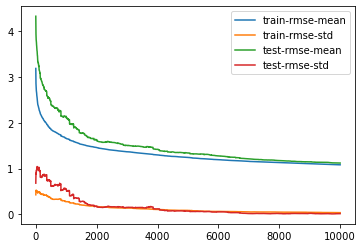

In [20]:
cv_model.plot.line()

In [29]:
import xgboost as xgb

xgtrain = xgb.DMatrix(data=train[features].values,
                      label=train[target].values)

parameters = {"eta":1,
              "gamma":0,
              "max_depth":10,
              "min_child_weight":1,
              "subsample":1,
              "colsample_bytree":1,
              "objective":"reg:squarederror"}

num_boost_round = 500
metric = "rmse"
early_stopping_rounds = 25

cv_model2 = xgb.cv(params=parameters, 
                   dtrain=xgtrain,
                   num_boost_round=num_boost_round,
                   folds=folds,
                   metrics=metric,
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=True,
                   seed=42)

[0]	train-rmse:2.18974+0.43225	test-rmse:2.76352+0.46460
[1]	train-rmse:2.00888+0.35908	test-rmse:2.59258+0.46655
[2]	train-rmse:1.75200+0.10697	test-rmse:2.07222+0.16945
[3]	train-rmse:1.68203+0.14292	test-rmse:1.93639+0.12610
[4]	train-rmse:1.65607+0.14371	test-rmse:1.85841+0.08268
[5]	train-rmse:1.57449+0.06791	test-rmse:1.77125+0.04965
[6]	train-rmse:1.53368+0.07263	test-rmse:1.69204+0.06331
[7]	train-rmse:1.51692+0.07877	test-rmse:1.65880+0.08973
[8]	train-rmse:1.50483+0.07198	test-rmse:1.64995+0.08692
[9]	train-rmse:1.46253+0.06954	test-rmse:1.52710+0.06061
[10]	train-rmse:1.42975+0.08578	test-rmse:1.46675+0.01674
[11]	train-rmse:1.41021+0.07820	test-rmse:1.46035+0.01577
[12]	train-rmse:1.38950+0.06577	test-rmse:1.43529+0.03677
[13]	train-rmse:1.37600+0.05922	test-rmse:1.41047+0.06001
[14]	train-rmse:1.34095+0.08846	test-rmse:1.38158+0.05767
[15]	train-rmse:1.33528+0.08691	test-rmse:1.37622+0.05706
[16]	train-rmse:1.30697+0.09581	test-rmse:1.33797+0.07405
[17]	train-rmse:1.30088+

[141]	train-rmse:0.74283+0.06346	test-rmse:0.73977+0.05852
[142]	train-rmse:0.74058+0.06248	test-rmse:0.73633+0.05963
[143]	train-rmse:0.73998+0.06247	test-rmse:0.73376+0.06170
[144]	train-rmse:0.73846+0.06268	test-rmse:0.73308+0.06219
[145]	train-rmse:0.73705+0.06267	test-rmse:0.73025+0.06127
[146]	train-rmse:0.73604+0.06234	test-rmse:0.72798+0.06049
[147]	train-rmse:0.73465+0.06257	test-rmse:0.72613+0.06091
[148]	train-rmse:0.73385+0.06238	test-rmse:0.72568+0.06080
[149]	train-rmse:0.73181+0.06309	test-rmse:0.72362+0.06119
[150]	train-rmse:0.73044+0.06253	test-rmse:0.72222+0.06023
[151]	train-rmse:0.72956+0.06268	test-rmse:0.72138+0.06027
[152]	train-rmse:0.72793+0.06310	test-rmse:0.71890+0.06200
[153]	train-rmse:0.72670+0.06284	test-rmse:0.71794+0.06143
[154]	train-rmse:0.72489+0.06277	test-rmse:0.71623+0.06115
[155]	train-rmse:0.72429+0.06319	test-rmse:0.71538+0.06172
[156]	train-rmse:0.72187+0.06253	test-rmse:0.71333+0.06023
[157]	train-rmse:0.72059+0.06242	test-rmse:0.71258+0.060

[280]	train-rmse:0.60351+0.05628	test-rmse:0.56740+0.05308
[281]	train-rmse:0.60260+0.05609	test-rmse:0.56637+0.05387
[282]	train-rmse:0.60223+0.05606	test-rmse:0.56531+0.05367
[283]	train-rmse:0.60130+0.05658	test-rmse:0.56431+0.05375
[284]	train-rmse:0.60090+0.05669	test-rmse:0.56411+0.05373
[285]	train-rmse:0.60018+0.05673	test-rmse:0.56308+0.05428
[286]	train-rmse:0.59987+0.05675	test-rmse:0.56274+0.05425
[287]	train-rmse:0.59970+0.05666	test-rmse:0.56247+0.05405
[288]	train-rmse:0.59913+0.05669	test-rmse:0.56202+0.05430
[289]	train-rmse:0.59838+0.05670	test-rmse:0.56159+0.05428
[290]	train-rmse:0.59790+0.05682	test-rmse:0.56093+0.05388
[291]	train-rmse:0.59710+0.05687	test-rmse:0.56001+0.05402
[292]	train-rmse:0.59650+0.05681	test-rmse:0.55940+0.05399
[293]	train-rmse:0.59588+0.05697	test-rmse:0.55858+0.05448
[294]	train-rmse:0.59512+0.05673	test-rmse:0.55696+0.05311
[295]	train-rmse:0.59306+0.05713	test-rmse:0.55545+0.05469
[296]	train-rmse:0.59271+0.05719	test-rmse:0.55482+0.054

[419]	train-rmse:0.53131+0.05000	test-rmse:0.48927+0.04716
[420]	train-rmse:0.53098+0.04994	test-rmse:0.48900+0.04717
[421]	train-rmse:0.53056+0.04974	test-rmse:0.48873+0.04677
[422]	train-rmse:0.53019+0.04983	test-rmse:0.48848+0.04687
[423]	train-rmse:0.52974+0.04965	test-rmse:0.48813+0.04669
[424]	train-rmse:0.52937+0.04969	test-rmse:0.48763+0.04659
[425]	train-rmse:0.52912+0.04982	test-rmse:0.48741+0.04664
[426]	train-rmse:0.52864+0.05000	test-rmse:0.48702+0.04664
[427]	train-rmse:0.52816+0.04991	test-rmse:0.48677+0.04673
[428]	train-rmse:0.52784+0.04988	test-rmse:0.48661+0.04668
[429]	train-rmse:0.52753+0.04981	test-rmse:0.48637+0.04663
[430]	train-rmse:0.52713+0.04979	test-rmse:0.48588+0.04669
[431]	train-rmse:0.52685+0.04990	test-rmse:0.48528+0.04677
[432]	train-rmse:0.52640+0.04981	test-rmse:0.48513+0.04669
[433]	train-rmse:0.52599+0.04984	test-rmse:0.48476+0.04651
[434]	train-rmse:0.52579+0.04985	test-rmse:0.48452+0.04649
[435]	train-rmse:0.52544+0.05003	test-rmse:0.48425+0.046

<AxesSubplot:>

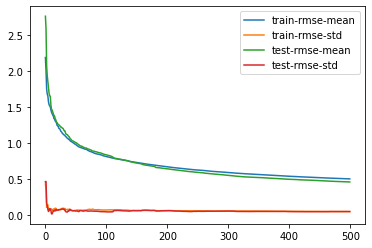

In [30]:
cv_model2.plot.line()

### Step 2 - Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

seed=42
grid_param = {"max_depth":[3, 5, 7, 10, 15],
              "min_child_weight":[1, 3, 5, 10]}

reg = XGBRegressor(learning_rate=1,
                   n_estimators=350,
                   max_depth=5,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1,
                   colsample_bytree=1,
                   objective="reg:squarederror",
                   nthread=4,
                   seed=seed)

gs = GridSearchCV(estimator=reg,
                  param_grid=grid_param,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  cv=folds,
                  verbose=2)

gs.fit(train[features],
       train[target])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 38.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 108.0min finished


[19:06:48] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


GridSearchCV(cv=[(array([      0,       1,       2, ..., 4098949, 4098950, 4098951]),
                  array([3734947, 3734948, 3734949, ..., 4098949, 4098950, 4098951])),
                 (array([4488756, 4488757, 4488758, ..., 8098020, 8098021, 8098022]),
                  array([7781923, 7781924, 7781925, ..., 8098020, 8098021, 8098022])),
                 (array([ 8428273,  8428274,  8428275, ..., 10913847, 10913848, 10913849]),
                  array([10675678, 10675679, 10675680, ...,...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=350, n_jobs=None, nthread=4,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42, subsample=1,
                                    tree_method=None, validate_parameters=None,
                                    

In [27]:
gs.best_score_

-0.12183076391617458

In [28]:
gs.best_params_

{'max_depth': 15, 'min_child_weight': 1}

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

seed=42
grid_param = {"max_depth":[10, 15, 20],
              "min_child_weight":[0.3, 0.7, 1, 1.3, 1.7]}

reg = XGBRegressor(learning_rate=1,
                   n_estimators=350,
                   max_depth=5,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1,
                   colsample_bytree=1,
                   objective="reg:squarederror",
                   nthread=1,
                   seed=seed)

gs = GridSearchCV(estimator=reg,
                  param_grid=grid_param,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=16,
                  cv=folds,
                  verbose=2)

gs.fit(train[features],
       train[target])

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed: 34.1min
[Parallel(n_jobs=16)]: Done  37 out of  45 | elapsed: 129.3min remaining: 28.0min
[Parallel(n_jobs=16)]: Done  45 out of  45 | elapsed: 142.6min finished


[22:02:20] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
-0.005031781891981761
{'max_depth': 20, 'min_child_weight': 0.3}


In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

seed=42
grid_param = {"max_depth":[15, 20, 25],
              "min_child_weight":[0.1, 0.3, 0.7]}

reg = XGBRegressor(learning_rate=1,
                   n_estimators=350,
                   max_depth=5,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1,
                   colsample_bytree=1,
                   objective="reg:squarederror",
                   nthread=4,
                   seed=seed)

gs = GridSearchCV(estimator=reg,
                  param_grid=grid_param,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  cv=folds,
                  verbose=2)

gs.fit(train[features],
       train[target])

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 91.3min finished


[00:10:25] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
-0.0019705467857420444
{'max_depth': 25, 'min_child_weight': 0.1}


In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

seed=42
grid_param = {"max_depth":[20, 25, 30],
              "min_child_weight":[0.03, 0.1, 0.3]}

reg = XGBRegressor(learning_rate=1,
                   n_estimators=350,
                   max_depth=5,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1,
                   colsample_bytree=1,
                   objective="reg:squarederror",
                   nthread=4,
                   seed=seed)

gs = GridSearchCV(estimator=reg,
                  param_grid=grid_param,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  cv=folds,
                  verbose=2)

gs.fit(train[features],
       train[target])

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 70.9min finished


[01:30:38] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
-0.0015605928686757882
{'max_depth': 30, 'min_child_weight': 0.03}


In [32]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

seed=42
grid_param = {"max_depth":[30, 35, 50, 75],
              "min_child_weight":[0.001, 0.003, 0.01]}

reg = XGBRegressor(learning_rate=1,
                   n_estimators=350,
                   max_depth=5,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1,
                   colsample_bytree=1,
                   objective="reg:squarederror",
                   nthread=4,
                   seed=seed)

gs = GridSearchCV(estimator=reg,
                  param_grid=grid_param,
                  scoring="neg_root_mean_squared_error",
                  n_jobs=4,
                  cv=folds,
                  verbose=2)

gs.fit(train[features],
       train[target])

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/rco/opt/anaconda3/envs/hse_comp_ds/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 41.2min finished


[10:32:30] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
-0.0012247612467035651
{'max_depth': 35, 'min_child_weight': 0.01}


In [ ]:
parameters = {"learning_rate":[0.03, 0.1, 0.3, 1],
              "min_child_weight":[1, 3, 10],
              "max_depth":[3, 10, 30],
              "gamma":[0, 0.1, 0.3, 1],
              "subsample":[0.1, 0.3, 1],
              "colsample_bytree":[0.1, 0.3, 1],
              "n_estimators":[10, 30, 100]}

## Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_jobs=1, verbosity=1)

parameters = {"learning_rate":[0.03, 0.1, 0.3, 1],
              "min_child_weight":[1, 3, 10],
              "max_depth":[3, 10, 30],
              "gamma":[0, 0.1, 0.3, 1],
              "subsample":[0.1, 0.3, 1],
              "colsample_bytree":[0.1, 0.3, 1],
              "n_estimators":[10, 30, 100]}

# X_eval = train.loc[val_3, features]
# y_eval = train.loc[val_3, target]

# fit_params={"early_stopping_rounds":10, 
#             "eval_metric" : "rmse", 
#             "eval_set" : [[X_eval, y_eval]]}

rs = RandomizedSearchCV(estimator=xgb,
                        param_distributions=parameters,
                        n_iter=48,
                        scoring="neg_mean_squared_error",
                        cv=folds,
                        verbose=2,
                        n_jobs=24,
                        pre_dispatch=24,
                        random_state=42)

# search = rs.fit(X=train[features], y=train[target])

In [ ]:
# search.best_params_

# {'subsample': 1,
#  'n_estimators': 30,
#  'min_child_weight': 10,
#  'max_depth': 30,
#  'learning_rate': 0.1,
#  'gamma': 0.3,
#  'colsample_bytree': 1}

## Learning Curve

In [ ]:
# xgb = XGBRegressor(tree_method="exact",
#                    objective="reg:squarederror",
#                    subsample=1,
#                    n_estimators=100,
#                    min_child_weight=10,
#                    max_depth=30,
#                    learning_rate=0.1,
#                    gamma=0.3,
#                    colsample_bytree=1,
#                    random_state=42, 
#                    n_jobs=24,
#                    verbosity=1)

xgb = XGBRegressor(tree_method="exact",
                   objective="reg:squarederror",
                   subsample=1,
                   n_estimators=5000,
                   min_child_weight=10,
                   max_depth=10,
                   learning_rate=1,
                   gamma=0.3,
                   colsample_bytree=1,
                   random_state=42, 
                   n_jobs=24,
                   verbosity=1)

In [ ]:
X_train = train.loc[train_all, features]
y_train = train.loc[train_all, target]
X_eval = train.loc[val_3, features]
y_eval = train.loc[val_3, target]
eval_set = [(X_train, y_train), (X_eval, y_eval)]

In [ ]:
model = None
# model = xgb.fit(X_train, y_train,
#                 eval_set=eval_set,
#                 eval_metric="rmse",
#                 verbose=True)

In [ ]:
from joblib import dump, load

model_name = "Model_XGBoost_Tuned_3000_estimators"

if model is not None:
    dump(model, Path(MODEL_PATH, model_filename+".joblib"))
else:
    model = load(Path(MODEL_PATH, model_name+".joblib"))
    

In [ ]:
print("train final score", model.evals_result_["validation_0"]["rmse"][-1:])

In [ ]:
print("val final score", model.evals_result_["validation_1"]["rmse"][-1:])

In [17]:
from sklearn.metrics import mean_squared_error

pred = model.predict(X_eval)
pred = np.clip(pred, 0, 20)

mean_squared_error(y_eval, pred, squared=False)

AttributeError: 'DataFrame' object has no attribute 'predict'

In [ ]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

## Predictions

In [ ]:
pred = pred_model.predict(test[features])
pred = np.clip(pred, 0, 20)

## Submission

In [ ]:
submission = pd.DataFrame({"ID":range(pred.shape[0]),
                           "item_cnt_month":pred})

sub_file_name = "submission_"+model_name+".csv"

submission[["ID", "item_cnt_month"]].to_csv(Path(MODEL_PATH, sub_file_name),
                                            index=False)

!kaggle competitions submit -c competitive-data-science-predict-future-sales -f $sub_file_name -m "Model_XGBoost_Tuned_3000_estimators"